In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from eda_utils import *

In [2]:
# set path
import os
os.chdir('..')

In [3]:
# set params for matplotlib and seaborn
set_params()

# get data
data = get_data()

# preprocess data
data = preprocess_data(data)

data

   AmountSold_by_Kilo  AvgPrice_per_Kilo  YearNum  MonthNum FishGroup Country
0         2385.445111           6.900461     2023         1       Cod     USA
1          215.003039           3.703762     2023         1   Haddock     USA
2           32.658689           3.924224     2023         1       Cod     USA
3         5855.430868           5.114718     2023         1   Haddock     USA
4         1518.629061           5.555642     2023         1      Hake     USA
OUTLIERS:
      YYYY/MM FishGroup    Country  AmountSold_by_Kilo  AvgPrice_per_Kilo  \
2340  2022-03       Cod  FAROE IS.                64.0               75.0   

     Imported  
2340      Yes  


YYYY/MM FishGroup    Country  AmountSold_by_Kilo  AvgPrice_per_Kilo  \
0     2004-01       Cod        USA        37891.790876           4.419322   
1     2004-01   Haddock        USA        24066.278996           3.743735   
2     2004-01      Hake        USA       103171.068030           2.091564   
3     2004-01   Pollock        USA        56597.962461           1.410748   
4     2004-01   Redfish        USA         6455.987880           1.807788   
...       ...       ...        ...                 ...                ...   
2662  2024-01   Haddock  FAROE IS.        92694.000000           3.702699   
2663  2024-01   Haddock    ICELAND       436025.000000           8.873429   
2664  2024-01   Haddock     NORWAY       578762.000000           3.324736   
2665  2024-01      Hake      SPAIN         2605.000000           3.795777   
2666  2024-01   Pollock    ICELAND        55205.000000           2.409329   

     Imported  
0          No  
1          No  
2          No  
3          No  
4          No  
...       ...  
2662      Yes  
2663      Yes  
2664      Yes  
2665      Yes  
2666      Yes  

[2666 rows x 6 columns]

In [4]:
data.groupby('Country')['AvgPrice_per_Kilo'].mean().sort_values(ascending=False)

Country
LATVIA                16.000689
NORWAY                 8.782617
GREENLAND              8.125947
ICELAND                7.697597
DENMARK                6.961678
NETHERLANDS            6.770562
GERMANY                6.714913
UNITED KINGDOM         6.400373
RUSSIAN FEDERATION     6.250318
POLAND                 6.234752
FAROE IS.              4.041017
USA                    3.745200
FRANCE                 3.661809
PORTUGAL               3.491549
SPAIN                  3.373768
ITALY                  3.168689
SWEDEN                 3.090004
MONTENEGRO             2.164168
GREECE                 2.092404
LITHUANIA              1.824148
UKRAINE                1.792243
ALBANIA                1.750000
BOSNIA-HERCEGOVINA     1.695254
CROATIA                1.552619
ROMANIA                1.533385
BULGARIA               1.461316
SERBIA & KOSOVO        1.347740
IRELAND                0.975000
Name: AvgPrice_per_Kilo, dtype: float64

### Countries Fishing In Barents Sea

In [5]:
countries = data['Country'].value_counts()[1:4].index.values
countries

array(['ICELAND', 'NORWAY', 'RUSSIAN FEDERATION'], dtype=object)

### Filter on Countries

In [6]:
data_filtered = data[data['Country'].isin(['USA', 'ICELAND', 'NORWAY', 'RUSSIAN FEDERATION'])]
data_filtered

YYYY/MM FishGroup  Country  AmountSold_by_Kilo  AvgPrice_per_Kilo  \
0     2004-01       Cod      USA        37891.790876           4.419322   
1     2004-01   Haddock      USA        24066.278996           3.743735   
2     2004-01      Hake      USA       103171.068030           2.091564   
3     2004-01   Pollock      USA        56597.962461           1.410748   
4     2004-01   Redfish      USA         6455.987880           1.807788   
...       ...       ...      ...                 ...                ...   
2660  2024-01       Cod  ICELAND       547613.000000          10.672972   
2661  2024-01       Cod   NORWAY       132717.000000           5.831393   
2663  2024-01   Haddock  ICELAND       436025.000000           8.873429   
2664  2024-01   Haddock   NORWAY       578762.000000           3.324736   
2666  2024-01   Pollock  ICELAND        55205.000000           2.409329   

     Imported  
0          No  
1          No  
2          No  
3          No  
4          No  
...       ...  
2660      Yes  
2661      Yes  
2663      Yes  
2664      Yes  
2666      Yes  

[2194 rows x 6 columns]

# Format Data for Regression (pivot tables)

In [7]:
# Drop the 'Country' column
data_without_country = data_filtered.drop('Country', axis=1)

# Create a unique identifier for each fish group by its import status
data_without_country['FishGroup_ImportStatusValue'] = np.where(data_without_country['Imported'] == 'Yes',
                                                          data_without_country['FishGroup'] + "_Imported_USD",
                                                          data_without_country['FishGroup'] + "_Domestic_USD")

# Create a unique identifier for each fish group by its import status
data_without_country['FishGroup_ImportStatusAmount'] = np.where(data_without_country['Imported'] == 'Yes',
                                                          data_without_country['FishGroup'] + "_Imported_Kilos",
                                                          data_without_country['FishGroup'] + "_Domestic_Kilos")

# Pivot the table to have dates as rows and the unique fish group import statuses as columns, with average prices as values
df_value = data_without_country.pivot_table(index='YYYY/MM', 
                                               columns='FishGroup_ImportStatusValue', 
                                               values='AvgPrice_per_Kilo',
                                               aggfunc='mean')
# Pivot the table to have dates as rows and the unique fish group import statuses as columns, with average prices as values
df_amount = data_without_country.pivot_table(index='YYYY/MM', 
                                               columns='FishGroup_ImportStatusAmount', 
                                               values='AmountSold_by_Kilo',
                                               aggfunc='sum')


In [8]:
data_without_country['FishGroup_ImportStatusValue'].unique()

array(['Cod_Domestic_USD', 'Haddock_Domestic_USD', 'Hake_Domestic_USD',
       'Pollock_Domestic_USD', 'Redfish_Domestic_USD', 'Cod_Imported_USD',
       'Haddock_Imported_USD', 'Pollock_Imported_USD',
       'Hake_Imported_USD', 'Redfish_Imported_USD'], dtype=object)

In [9]:
data_without_country['FishGroup_ImportStatusAmount'].unique()

array(['Cod_Domestic_Kilos', 'Haddock_Domestic_Kilos',
       'Hake_Domestic_Kilos', 'Pollock_Domestic_Kilos',
       'Redfish_Domestic_Kilos', 'Cod_Imported_Kilos',
       'Haddock_Imported_Kilos', 'Pollock_Imported_Kilos',
       'Hake_Imported_Kilos', 'Redfish_Imported_Kilos'], dtype=object)

### Check value_df distributions:

In [10]:
df_value

FishGroup_ImportStatusValue  Cod_Domestic_USD  Cod_Imported_USD  \
YYYY/MM                                                           
2004-01                              4.419322               NaN   
2004-02                              3.637451               NaN   
2004-03                              3.444920               NaN   
2004-04                              3.179624               NaN   
2004-05                              3.937936               NaN   
...                                       ...               ...   
2023-09                              7.832365         10.271607   
2023-10                              5.584164         11.177861   
2023-11                              6.185745          9.389704   
2023-12                              6.994718         12.500403   
2024-01                                   NaN          8.252182   

FishGroup_ImportStatusValue  Haddock_Domestic_USD  Haddock_Imported_USD  \
YYYY/MM                                                                   
2004-01                                  3.743735                   NaN   
2004-02                                  2.893345                   NaN   
2004-03                                  3.208133                   NaN   
2004-04                                  2.655904                   NaN   
2004-05                                  2.268643                   NaN   
...                                           ...                   ...   
2023-09                                  4.656625              6.936796   
2023-10                                  4.012876              6.809827   
2023-11                                  3.788009              6.481896   
2023-12                                  4.975382              6.607995   
2024-01                                       NaN              6.099083   

FishGroup_ImportStatusValue  Hake_Domestic_USD  Hake_Imported_USD  \
YYYY/MM                                                             
2004-01                               2.091564                NaN   
2004-02                               1.658112                NaN   
2004-03                               2.035425                NaN   
2004-04                               3.226395                NaN   
2004-05                               1.743420                NaN   
...                                        ...                ...   
2023-09                               5.330927                NaN   
2023-10                               3.343172                NaN   
2023-11                               4.816630                NaN   
2023-12                               4.811291                NaN   
2024-01                                    NaN                NaN   

FishGroup_ImportStatusValue  Pollock_Domestic_USD  Pollock_Imported_USD  \
YYYY/MM                                                                   
2004-01                                  1.410748                   NaN   
2004-02                                  1.519010                   NaN   
2004-03                                  1.737086                   NaN   
2004-04                                  1.884585                   NaN   
2004-05                                  1.224154                   NaN   
...                                           ...                   ...   
2023-09                                  6.659265              4.950753   
2023-10                                  5.567629                   NaN   
2023-11                                  5.883270              7.323531   
2023-12                                  5.062514              8.124016   
2024-01                                       NaN              2.409329   

FishGroup_ImportStatusValue  Redfish_Domestic_USD  Redfish_Imported_USD  
YYYY/MM                                                                  
2004-01                                  1.807788                   NaN  
2004-02                                  1.124356       

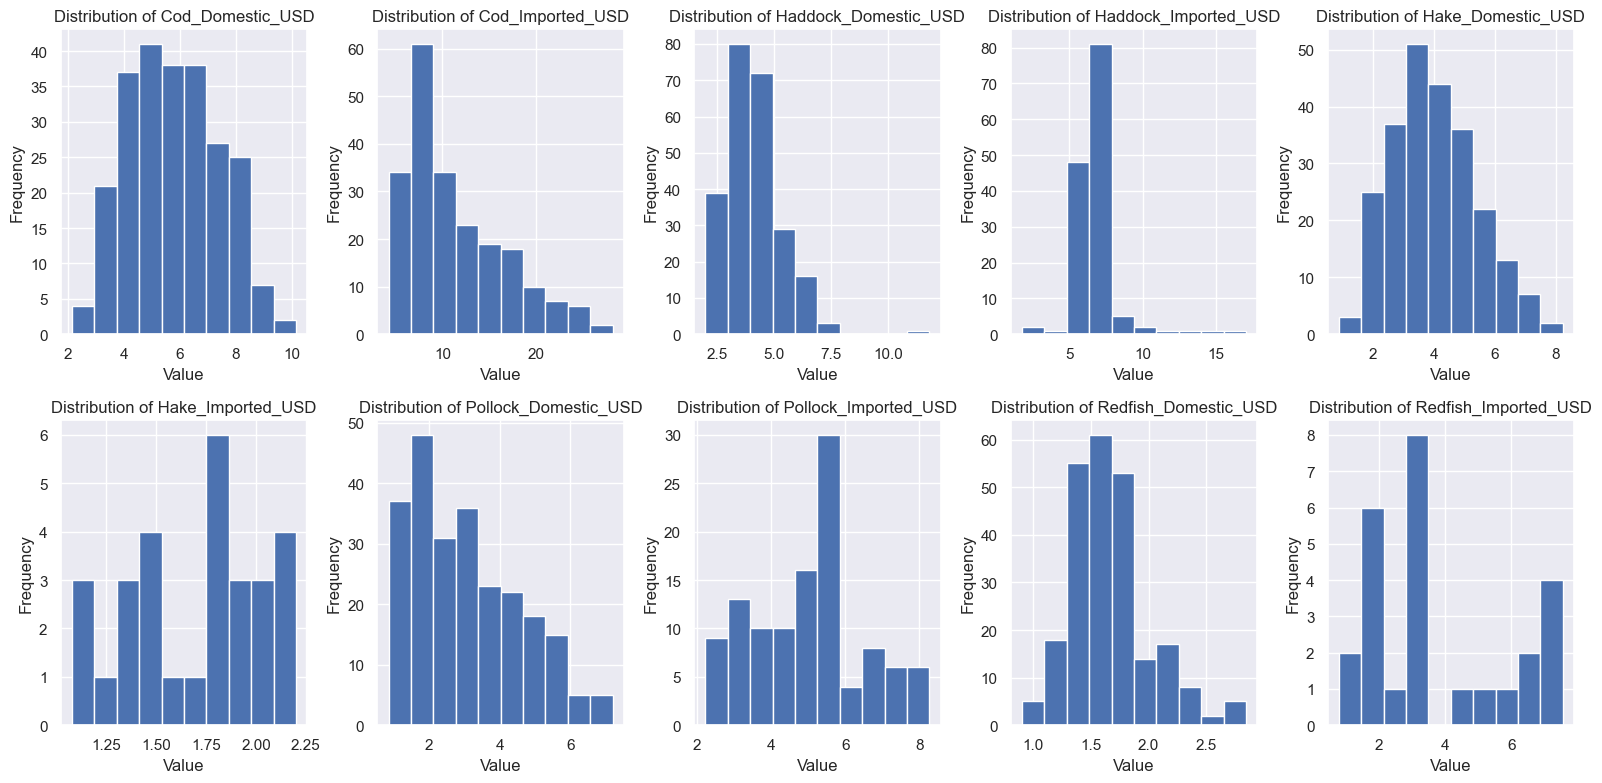

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

for n, column in enumerate(df_value.columns):
    i = n // 5
    j = n % 5
    ax[i, j].hist(df_value[column], bins=10)  
    ax[i, j].set_title(f'Distribution of {column}')
    ax[i, j].set_xlabel(f'Value')
    ax[i, j].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

### Check amount_df distributions:

In [12]:
df_amount

FishGroup_ImportStatusAmount  Cod_Domestic_Kilos  Cod_Imported_Kilos  \
YYYY/MM                                                                
2004-01                             37891.790876                 NaN   
2004-02                             57071.967051                 NaN   
2004-03                             94923.388158                 NaN   
2004-04                            114840.199218                 NaN   
2004-05                             46999.029311                 NaN   
...                                          ...                 ...   
2023-09                               982.482242            550803.0   
2023-10                              2737.886801            378040.0   
2023-11                              1918.244414            522584.0   
2023-12                              2224.873221            466942.0   
2024-01                                      NaN            680330.0   

FishGroup_ImportStatusAmount  Haddock_Domestic_Kilos  Haddock_Imported_Kilos  \
YYYY/MM                                                                        
2004-01                                 24066.278996                     NaN   
2004-02                                120841.687003                     NaN   
2004-03                                 80199.308724                     NaN   
2004-04                                117251.499125                     NaN   
2004-05                                 30582.594733                     NaN   
...                                              ...                     ...   
2023-09                                 12261.069935                435693.0   
2023-10                                 10651.722292                485924.0   
2023-11                                  7394.018017                915477.0   
2023-12                                 15505.166423                715398.0   
2024-01                                          NaN               1014787.0   

FishGroup_ImportStatusAmount  Hake_Domestic_Kilos  Hake_Imported_Kilos  \
YYYY/MM                                                                  
2004-01                             103171.068030                  NaN   
2004-02                             139801.417024                  NaN   
2004-03                             160185.428781                  NaN   
2004-04                              99076.031243                  NaN   
2004-05                             149485.625641                  NaN   
...                                           ...                  ...   
2023-09                              15318.286145                  NaN   
2023-10                              13815.986429                  NaN   
2023-11                               6911.848754                  NaN   
2023-12                               5860.420390                  NaN   
2024-01                                       NaN                  NaN   

FishGroup_ImportStatusAmount  Pollock_Domestic_Kilos  Pollock_Imported_Kilos  \
YYYY/MM                                                                        
2004-01                                 56597.962461                     NaN   
2004-02                                120811.749871                     NaN   
2004-03                                174808.810589                     NaN   
2004-04                                146683.328646                     NaN   
2004-05                                114421.986556                     NaN   
...                                              ...                     ...   
2023-09                                  2497.936152                  3919.0   
2023-10                                 14582.558445                     NaN   
2023-11                                  9647.013998                 29212.0   
2023-12                                 16793.823879                  1016.0   
2024-01                                          NaN                 55205.0   

FishGroup_ImportSt

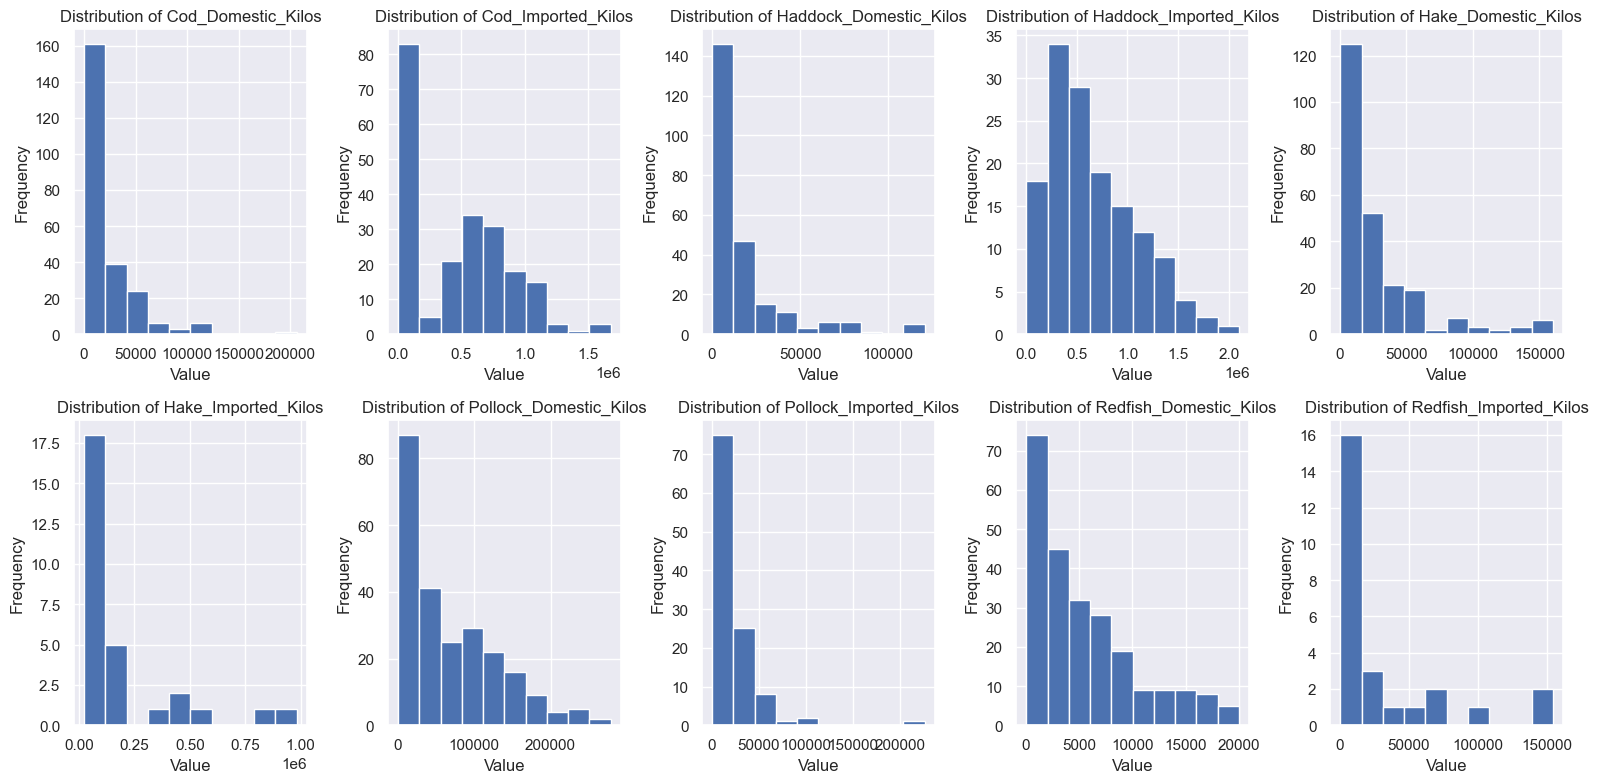

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

for n, column in enumerate(df_amount.columns):
    i = n // 5
    j = n % 5
    ax[i, j].hist(df_amount[column], bins=10)  
    ax[i, j].set_title(f'Distribution of {column}')
    ax[i, j].set_xlabel(f'Value')
    ax[i, j].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

### Log Transform amount_df:

/var/folders/92/fsnyg0n57cx169y7qtzjg3_w0000gn/T/ipykernel_3920/1342451315.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_amount = df_amount.applymap(lambda x: np.log(x))


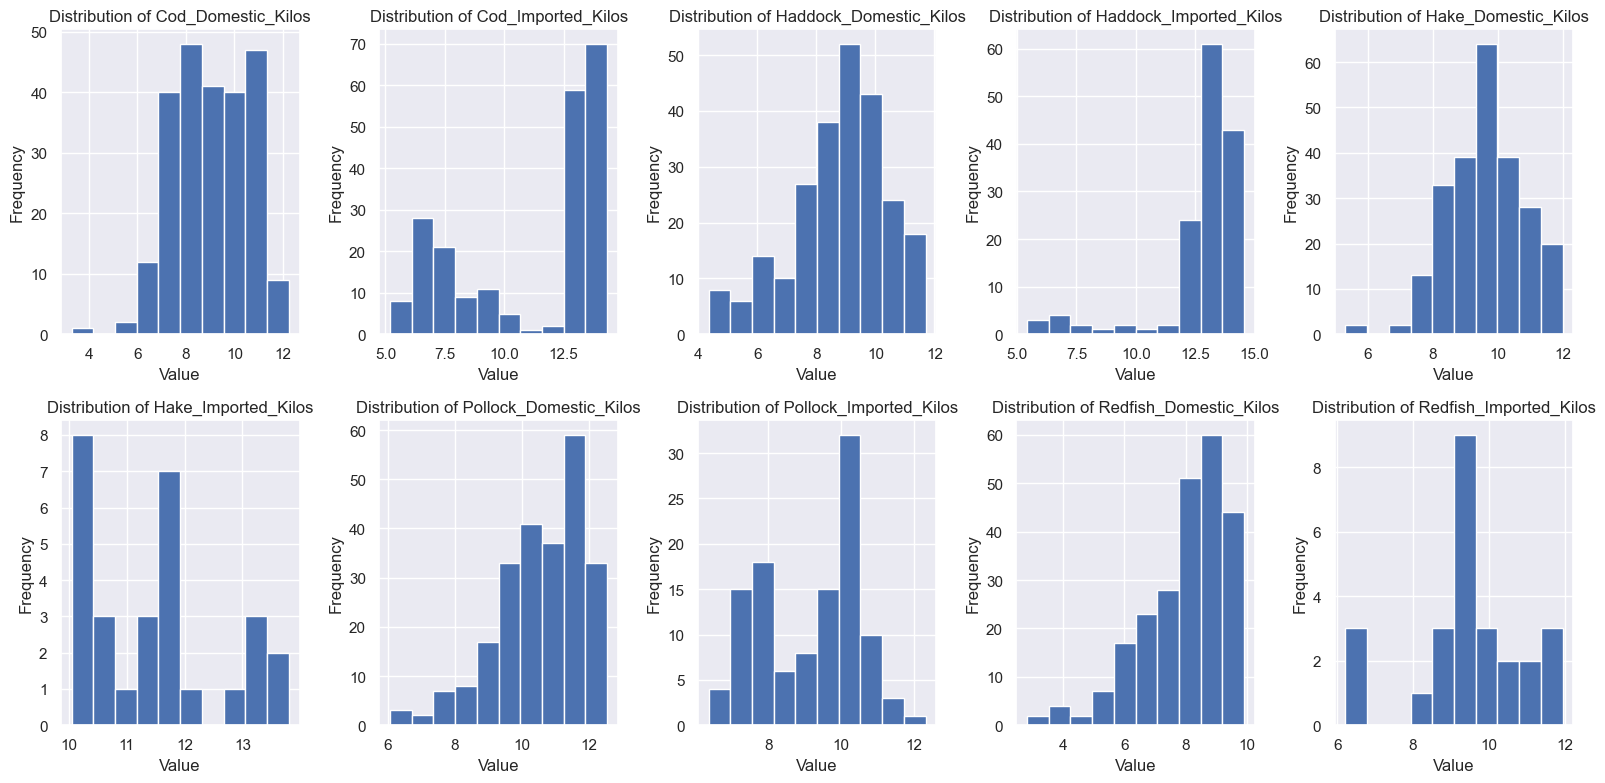

In [14]:
log_transform_amount = True
if log_transform_amount:
    df_amount = df_amount.applymap(lambda x: np.log(x))

    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

    for n, column in enumerate(df_amount.columns):
        i = n // 5
        j = n % 5
        ax[i, j].hist(df_amount[column], bins=10)  # Adjust the number of bins as needed
        ax[i, j].set_title(f'Distribution of {column}')
        ax[i, j].set_xlabel(f'Value')
        ax[i, j].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()


In [15]:
df_combined = df_value.join(df_amount)
df_combined

Cod_Domestic_USD  Cod_Imported_USD  Haddock_Domestic_USD  \
YYYY/MM                                                             
2004-01          4.419322               NaN              3.743735   
2004-02          3.637451               NaN              2.893345   
2004-03          3.444920               NaN              3.208133   
2004-04          3.179624               NaN              2.655904   
2004-05          3.937936               NaN              2.268643   
...                   ...               ...                   ...   
2023-09          7.832365         10.271607              4.656625   
2023-10          5.584164         11.177861              4.012876   
2023-11          6.185745          9.389704              3.788009   
2023-12          6.994718         12.500403              4.975382   
2024-01               NaN          8.252182                   NaN   

         Haddock_Imported_USD  Hake_Domestic_USD  Hake_Imported_USD  \
YYYY/MM                                                               
2004-01                   NaN           2.091564                NaN   
2004-02                   NaN           1.658112                NaN   
2004-03                   NaN           2.035425                NaN   
2004-04                   NaN           3.226395                NaN   
2004-05                   NaN           1.743420                NaN   
...                       ...                ...                ...   
2023-09              6.936796           5.330927                NaN   
2023-10              6.809827           3.343172                NaN   
2023-11              6.481896           4.816630                NaN   
2023-12              6.607995           4.811291                NaN   
2024-01              6.099083                NaN                NaN   

         Pollock_Domestic_USD  Pollock_Imported_USD  Redfish_Domestic_USD  \
YYYY/MM                                                                     
2004-01              1.410748                   NaN              1.807788   
2004-02              1.519010                   NaN              1.124356   
2004-03              1.737086                   NaN              1.455049   
2004-04              1.884585                   NaN              1.455049   
2004-05              1.224154                   NaN              1.521188   
...                       ...                   ...                   ...   
2023-09              6.659265              4.950753              1.433003   
2023-10              5.567629                   NaN              1.300726   
2023-11              5.883270              7.323531              1.631419   
2023-12              5.062514              8.124016              1.521188   
2024-01                   NaN              2.409329                   NaN   

         Redfish_Imported_USD  Cod_Domestic_Kilos  Cod_Imported_Kilos  \
YYYY/MM                                                                 
2004-01                   NaN           10.542490                 NaN   
2004-02                   NaN           10.952068                 NaN   
2004-03                   NaN           11.460825                 NaN   
2004-04                   NaN           11.651297                 NaN   
2004-05                   NaN           10.757882                 NaN   
...                       ...                 ...                 ...   
2023-09                   NaN            6.890082           13.219132   
2023-10              1.797368            7.914942           12.842755   
2023-11                   NaN            7.559166           13.166541   
2023-12                   NaN            7.707455           13.053960   
2024-01                   NaN                 NaN           13.430333   

         Haddock_Domestic_Kilos  Haddock_Imported_Kilos  Hake_Domestic_Kilos  \
YYYY/MM                                                                        
2004-01               10.088567                     NaN            11.54414

<Axes: >

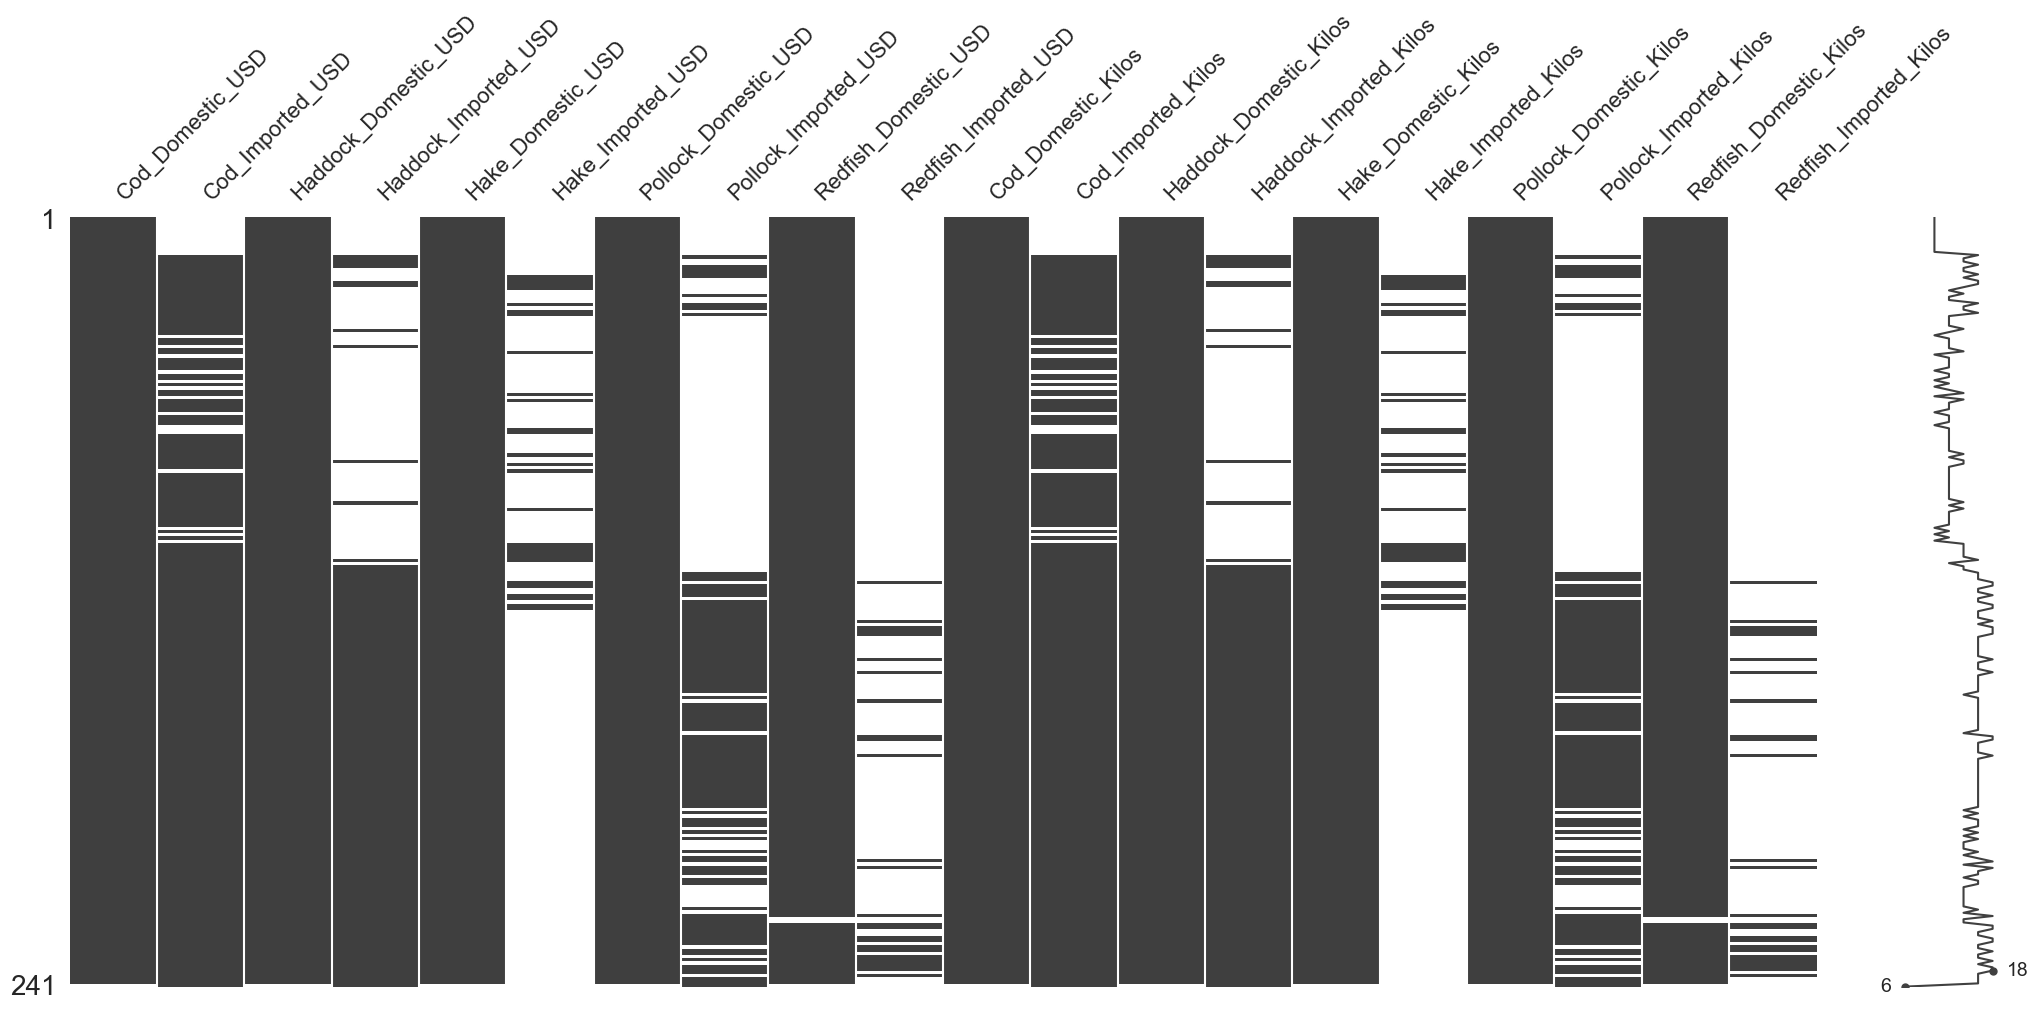

In [16]:
import missingno as msn



msn.matrix(df_combined)


In [17]:
# Filtering the DataFrame for a range of periods
start_period = pd.Period('2014-01', freq='M')
end_period = pd.Period('2024-04', freq='M')
filtered_df_range = df_combined[(df_combined.index >= start_period) & (df_combined.index <= end_period)].copy()


<Axes: >

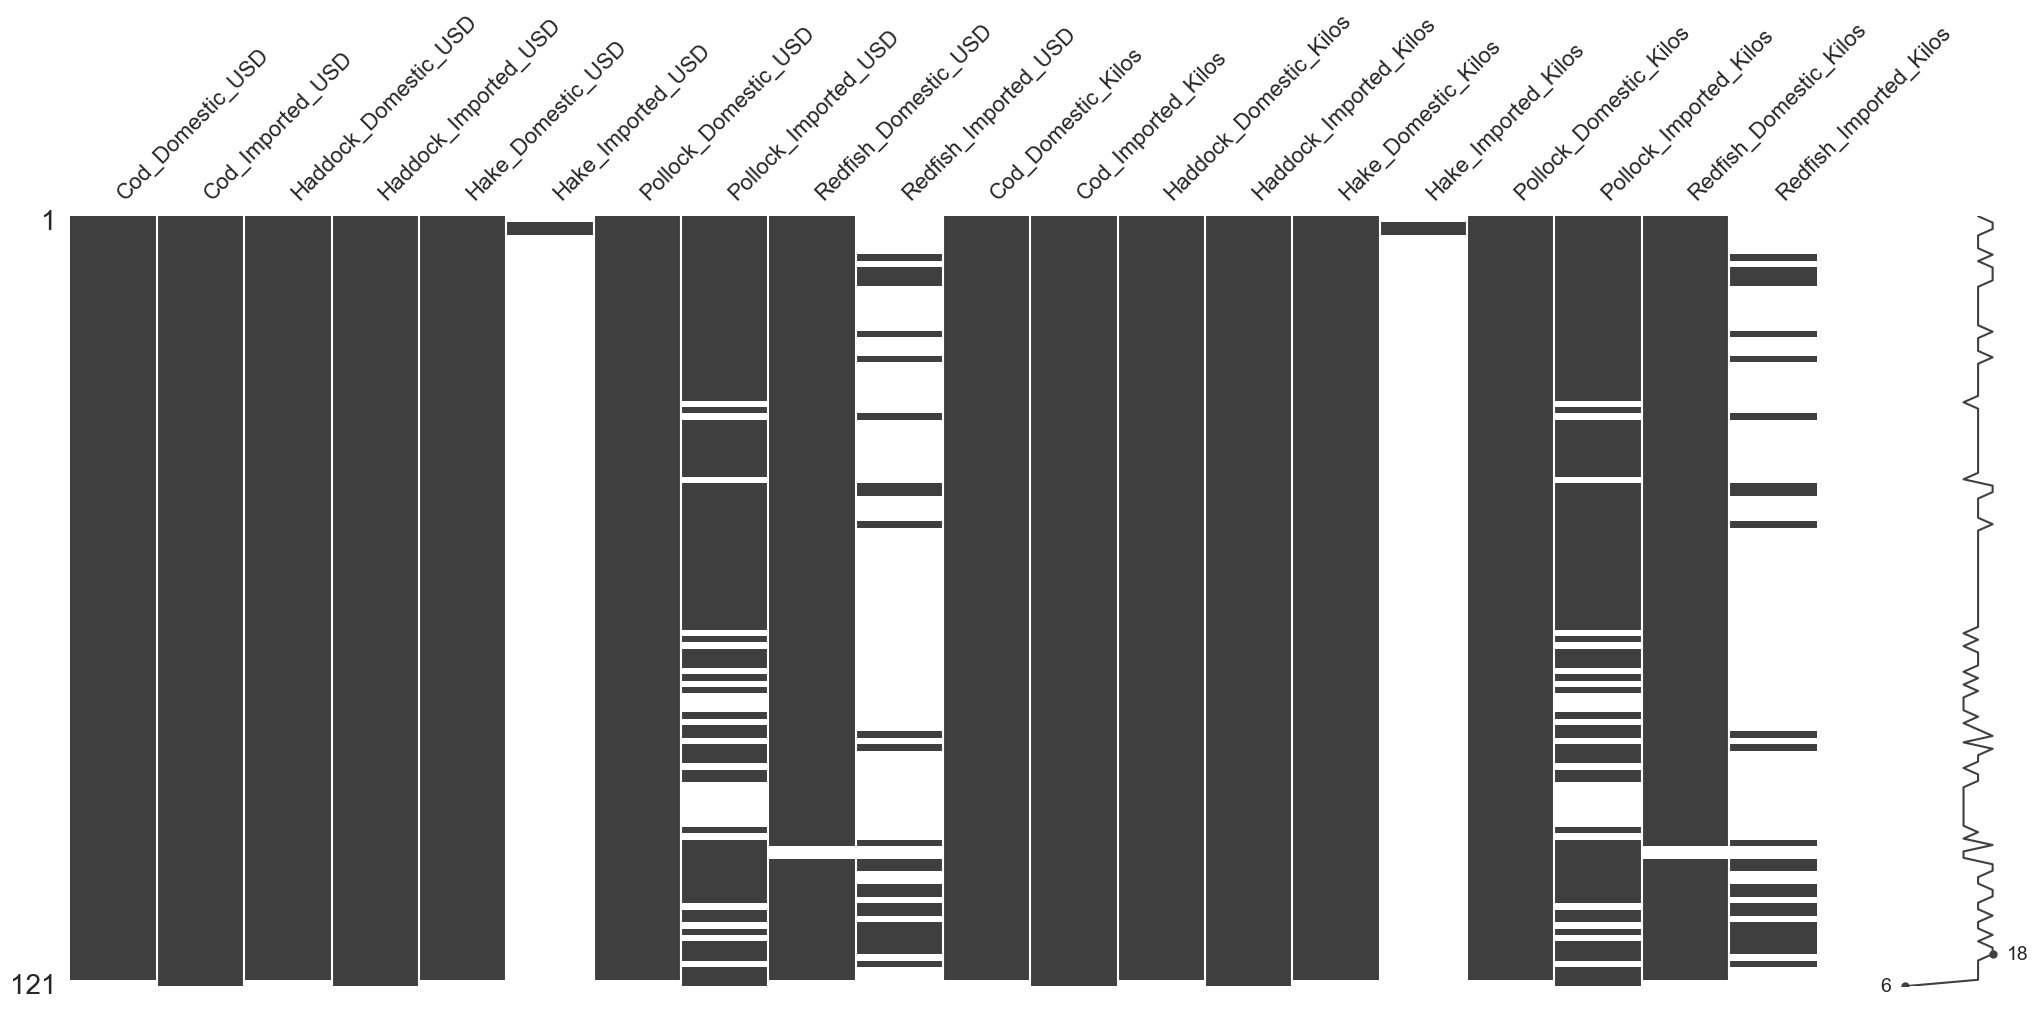

In [18]:
msn.matrix(filtered_df_range)

<Axes: >

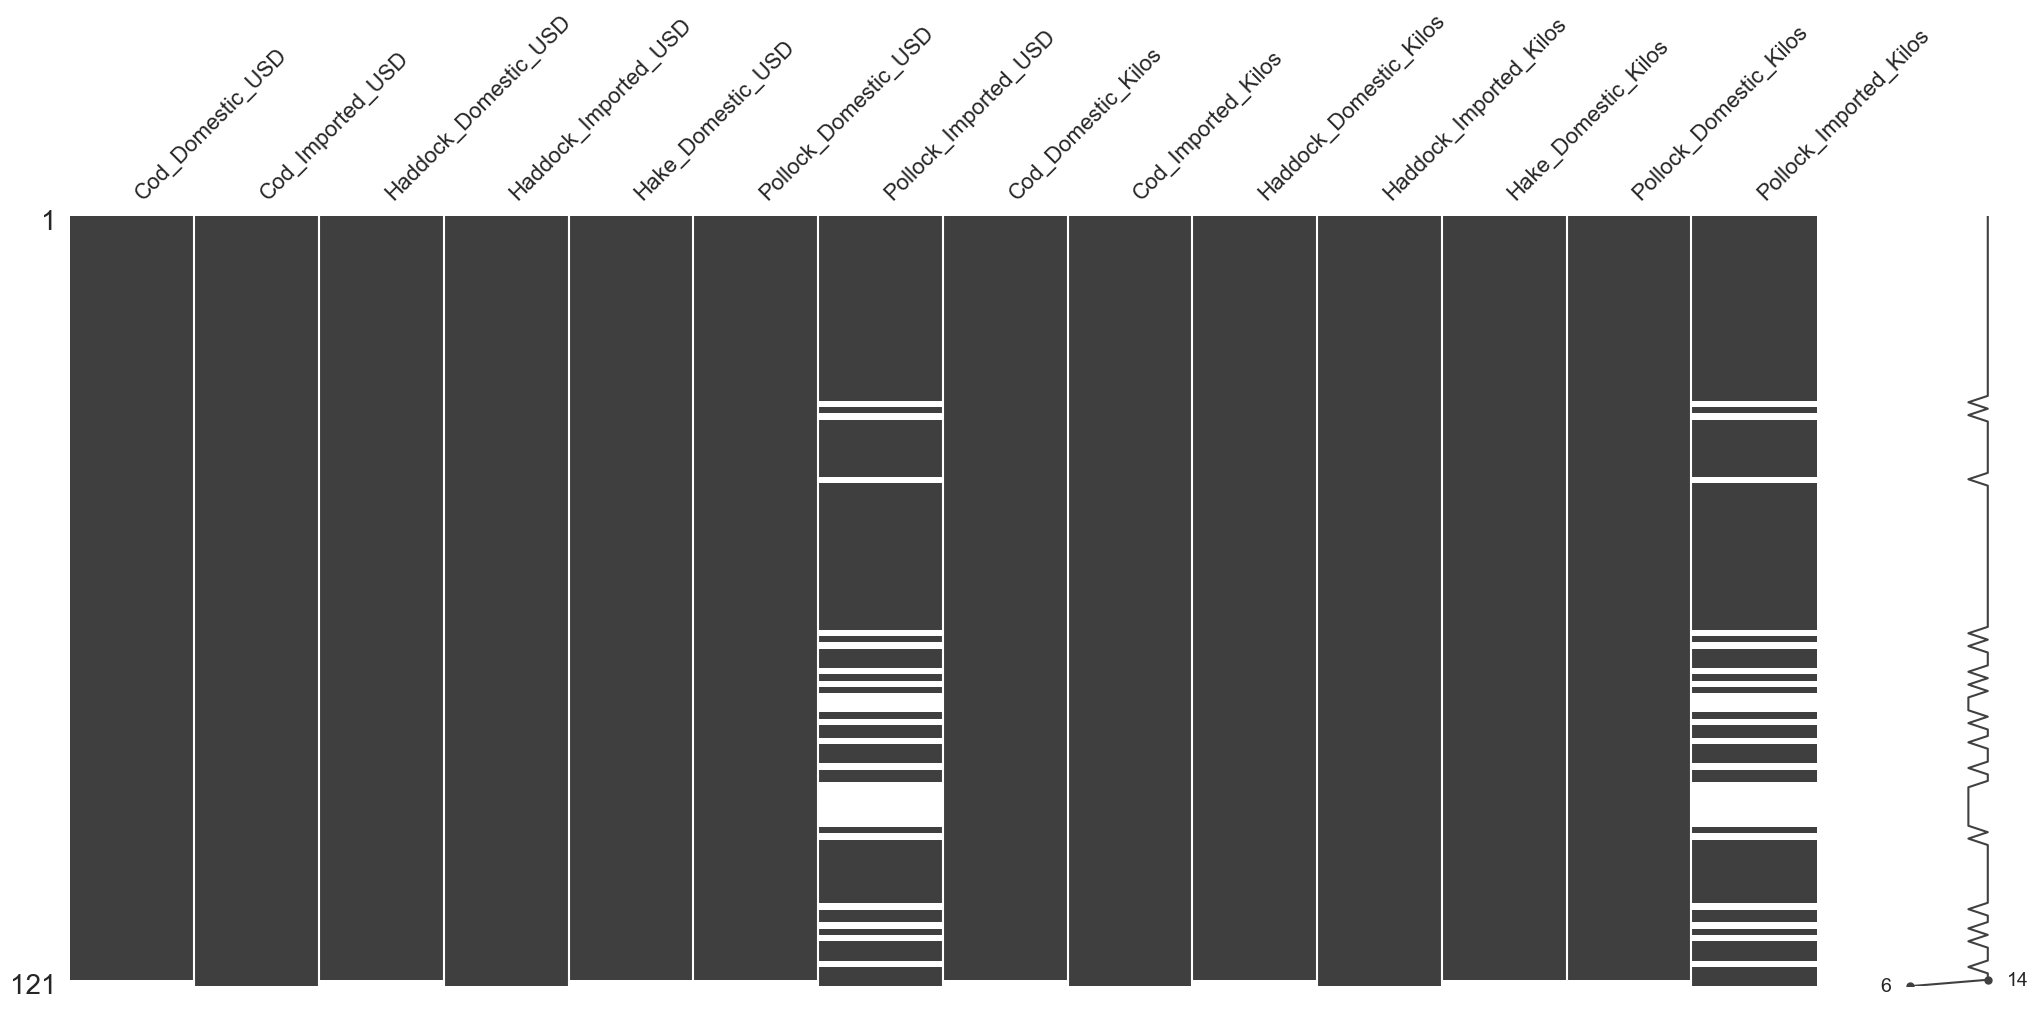

In [19]:
filtered_df_range = filtered_df_range.drop(['Hake_Imported_USD', 'Hake_Imported_Kilos', 'Redfish_Imported_USD', 'Redfish_Domestic_USD', 'Redfish_Domestic_Kilos', 'Redfish_Imported_Kilos'], axis=1)
msn.matrix(filtered_df_range)

# Impute Values for Imported Pollock

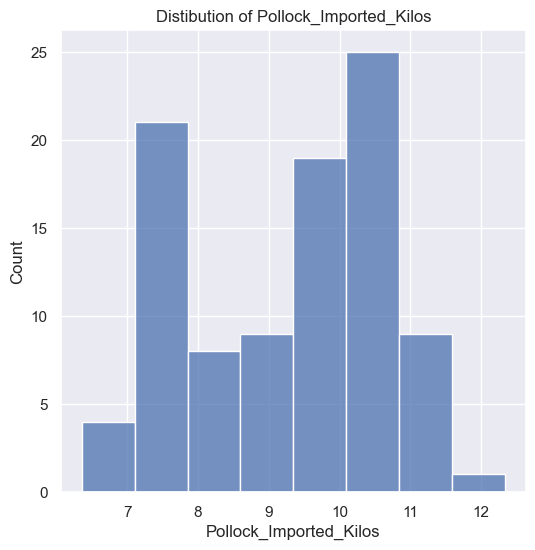

Pollock_Imported_Kilos Mean:  9.226821234604111


In [20]:
plt.figure(figsize=(6, 6))
sns.histplot(data=filtered_df_range, x='Pollock_Imported_Kilos')
plt.title('Distibution of Pollock_Imported_Kilos')
plt.show();
print('Pollock_Imported_Kilos Mean: ', filtered_df_range['Pollock_Imported_Kilos'].mean())

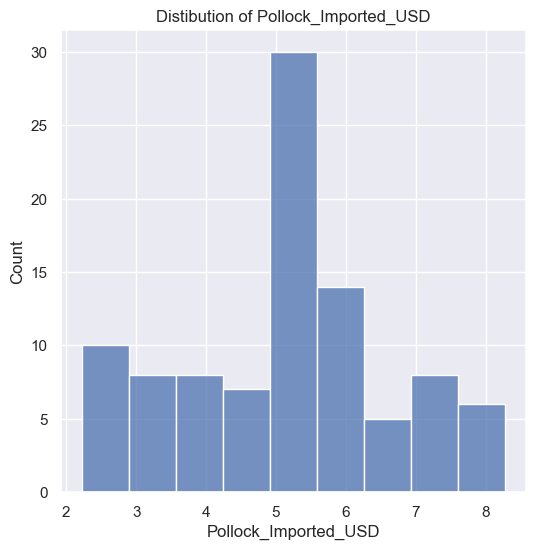

Pollock_Imported_USD Mean:  5.148378808332543


In [21]:
plt.figure(figsize=(6, 6))
sns.histplot(data=filtered_df_range, x='Pollock_Imported_USD')
plt.title('Distibution of Pollock_Imported_USD')
plt.show();

print('Pollock_Imported_USD Mean: ', filtered_df_range['Pollock_Imported_USD'].mean())

In [22]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

cols_to_impute = ['Pollock_Imported_Kilos', 'Pollock_Imported_USD']

filtered_df_range[cols_to_impute] = imp_mean.fit_transform(filtered_df_range[cols_to_impute])

### Drop NaN Values:

<Axes: >

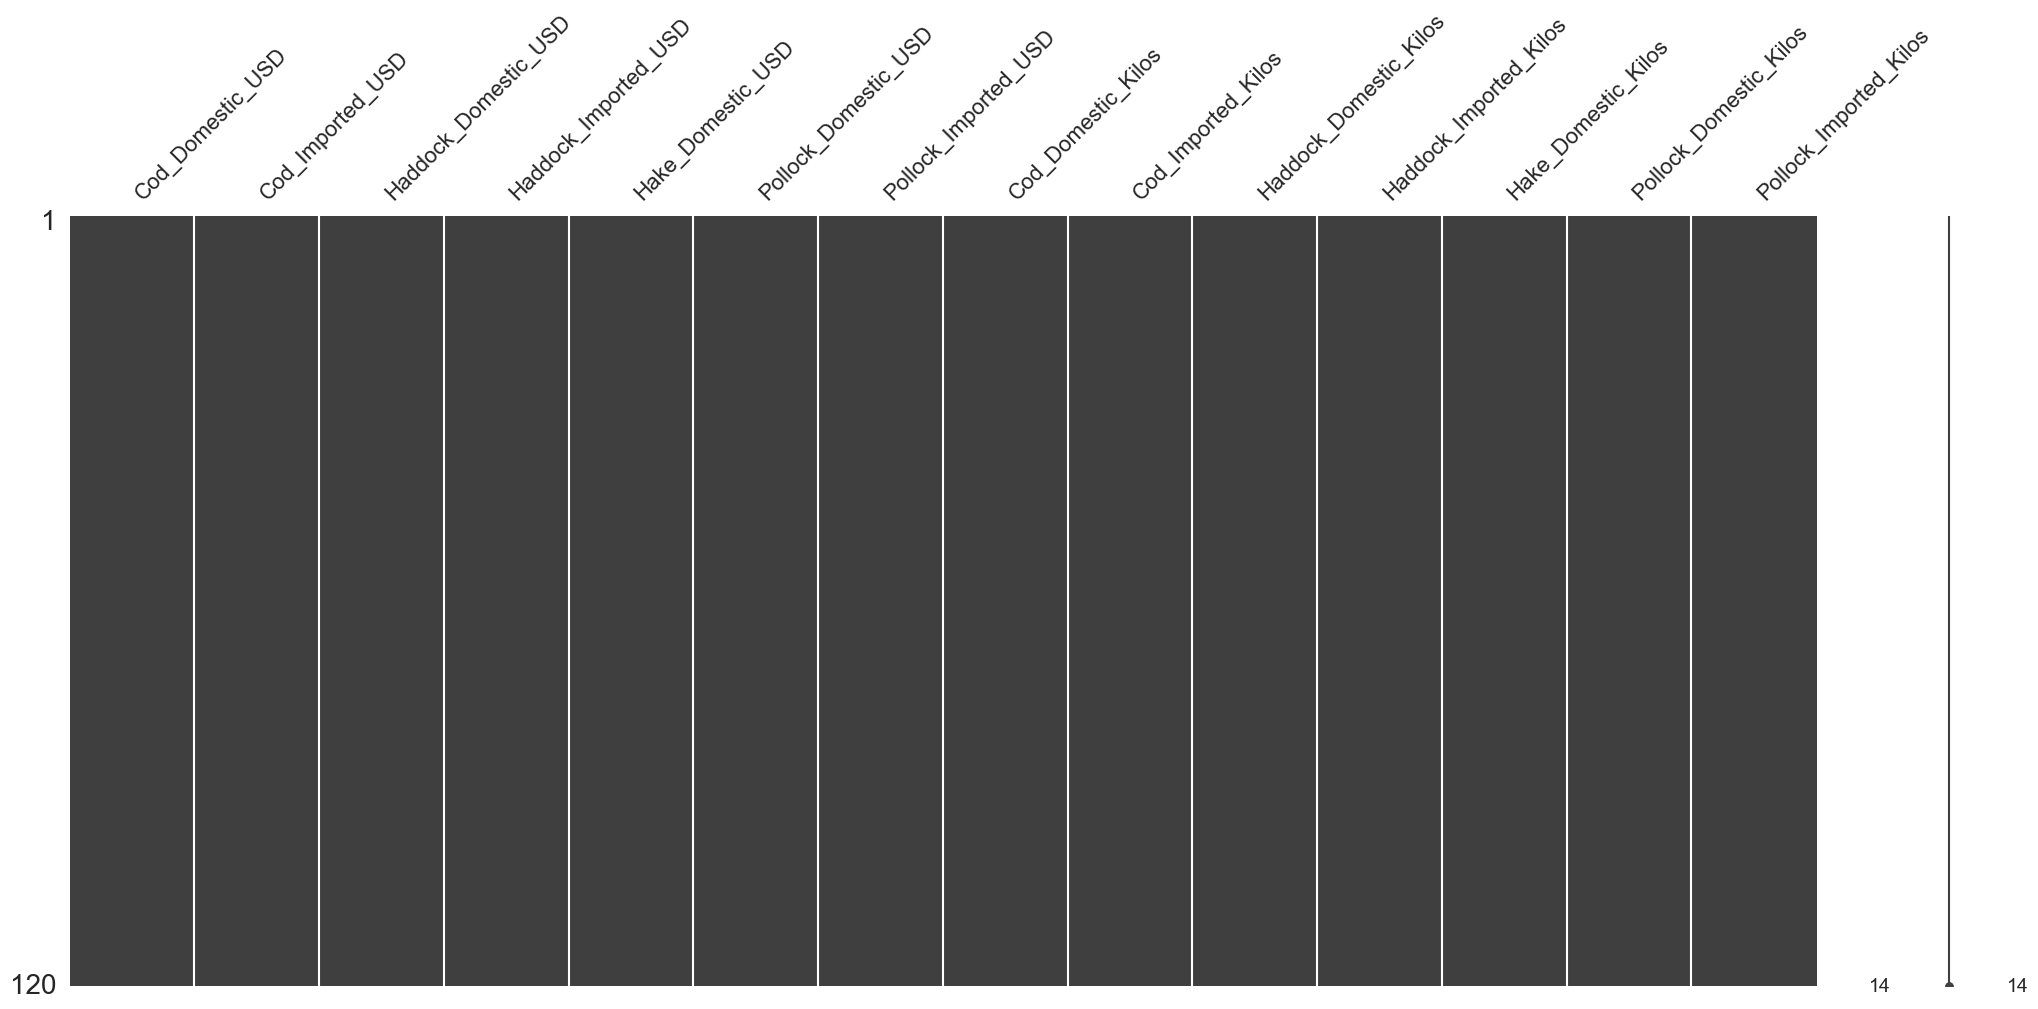

In [23]:
filtered_df_range.dropna(axis=0, inplace=True)
msn.matrix(filtered_df_range)

### Visualize:

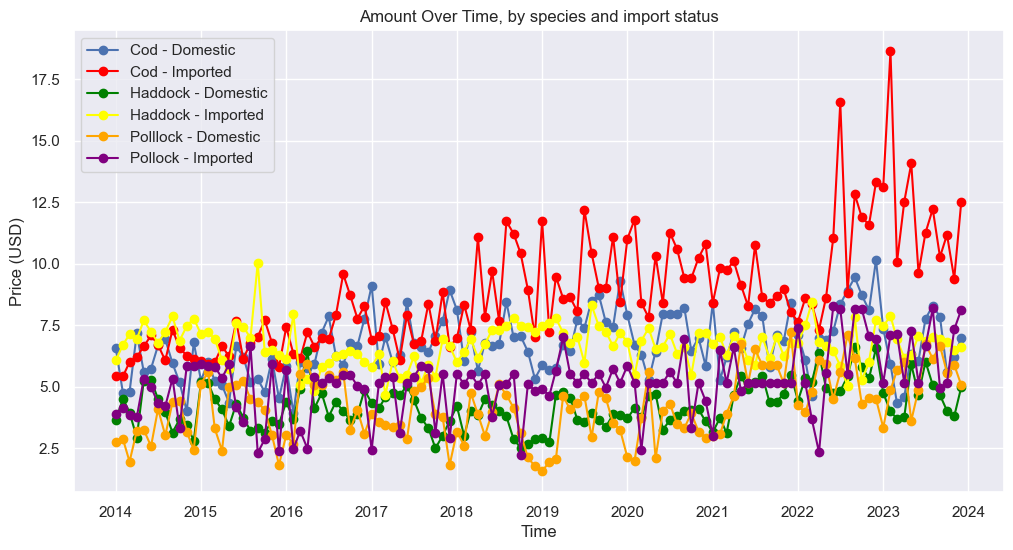

In [24]:
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Cod_Domestic_USD, marker='o', label='Cod - Domestic')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Cod_Imported_USD, marker='o', color='red', label='Cod - Imported')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Haddock_Domestic_USD, marker='o', color='green', label='Haddock - Domestic')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Haddock_Imported_USD, marker='o', color='yellow', label='Haddock - Imported')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Pollock_Domestic_USD, marker='o', color='orange', label='Polllock - Domestic')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Pollock_Imported_USD, marker='o', color='purple', label='Pollock - Imported')
plt.legend()
plt.title('Amount Over Time, by species and import status')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.show();

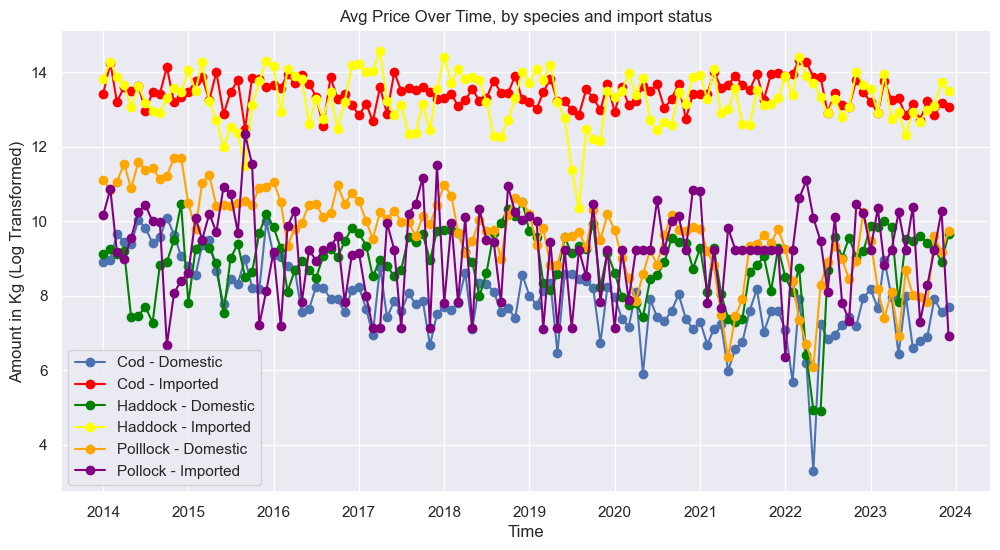

In [25]:
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Cod_Domestic_Kilos, marker='o', label='Cod - Domestic')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Cod_Imported_Kilos, marker='o', color='red', label='Cod - Imported')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Haddock_Domestic_Kilos, marker='o', color='green', label='Haddock - Domestic')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Haddock_Imported_Kilos, marker='o', color='yellow', label='Haddock - Imported')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Pollock_Domestic_Kilos, marker='o', color='orange', label='Polllock - Domestic')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Pollock_Imported_Kilos, marker='o', color='purple', label='Pollock - Imported')
plt.legend()
plt.title('Avg Price Over Time, by species and import status')
plt.xlabel('Time')
plt.ylabel('Amount in Kg (Log Transformed)')
plt.show();

# Correlations

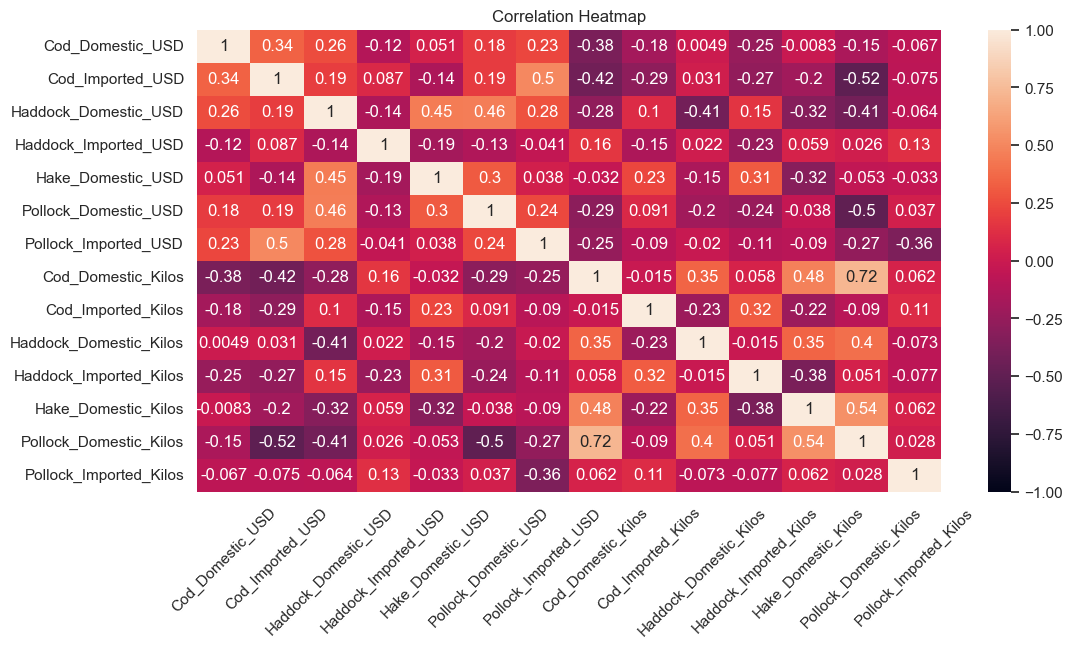

In [26]:
sns.heatmap(filtered_df_range.corr(), vmin=-1, vmax=1, annot=True)
plt.xticks(rotation=45)
plt.title('Correlation Heatmap')
plt.show();

# Pairplots

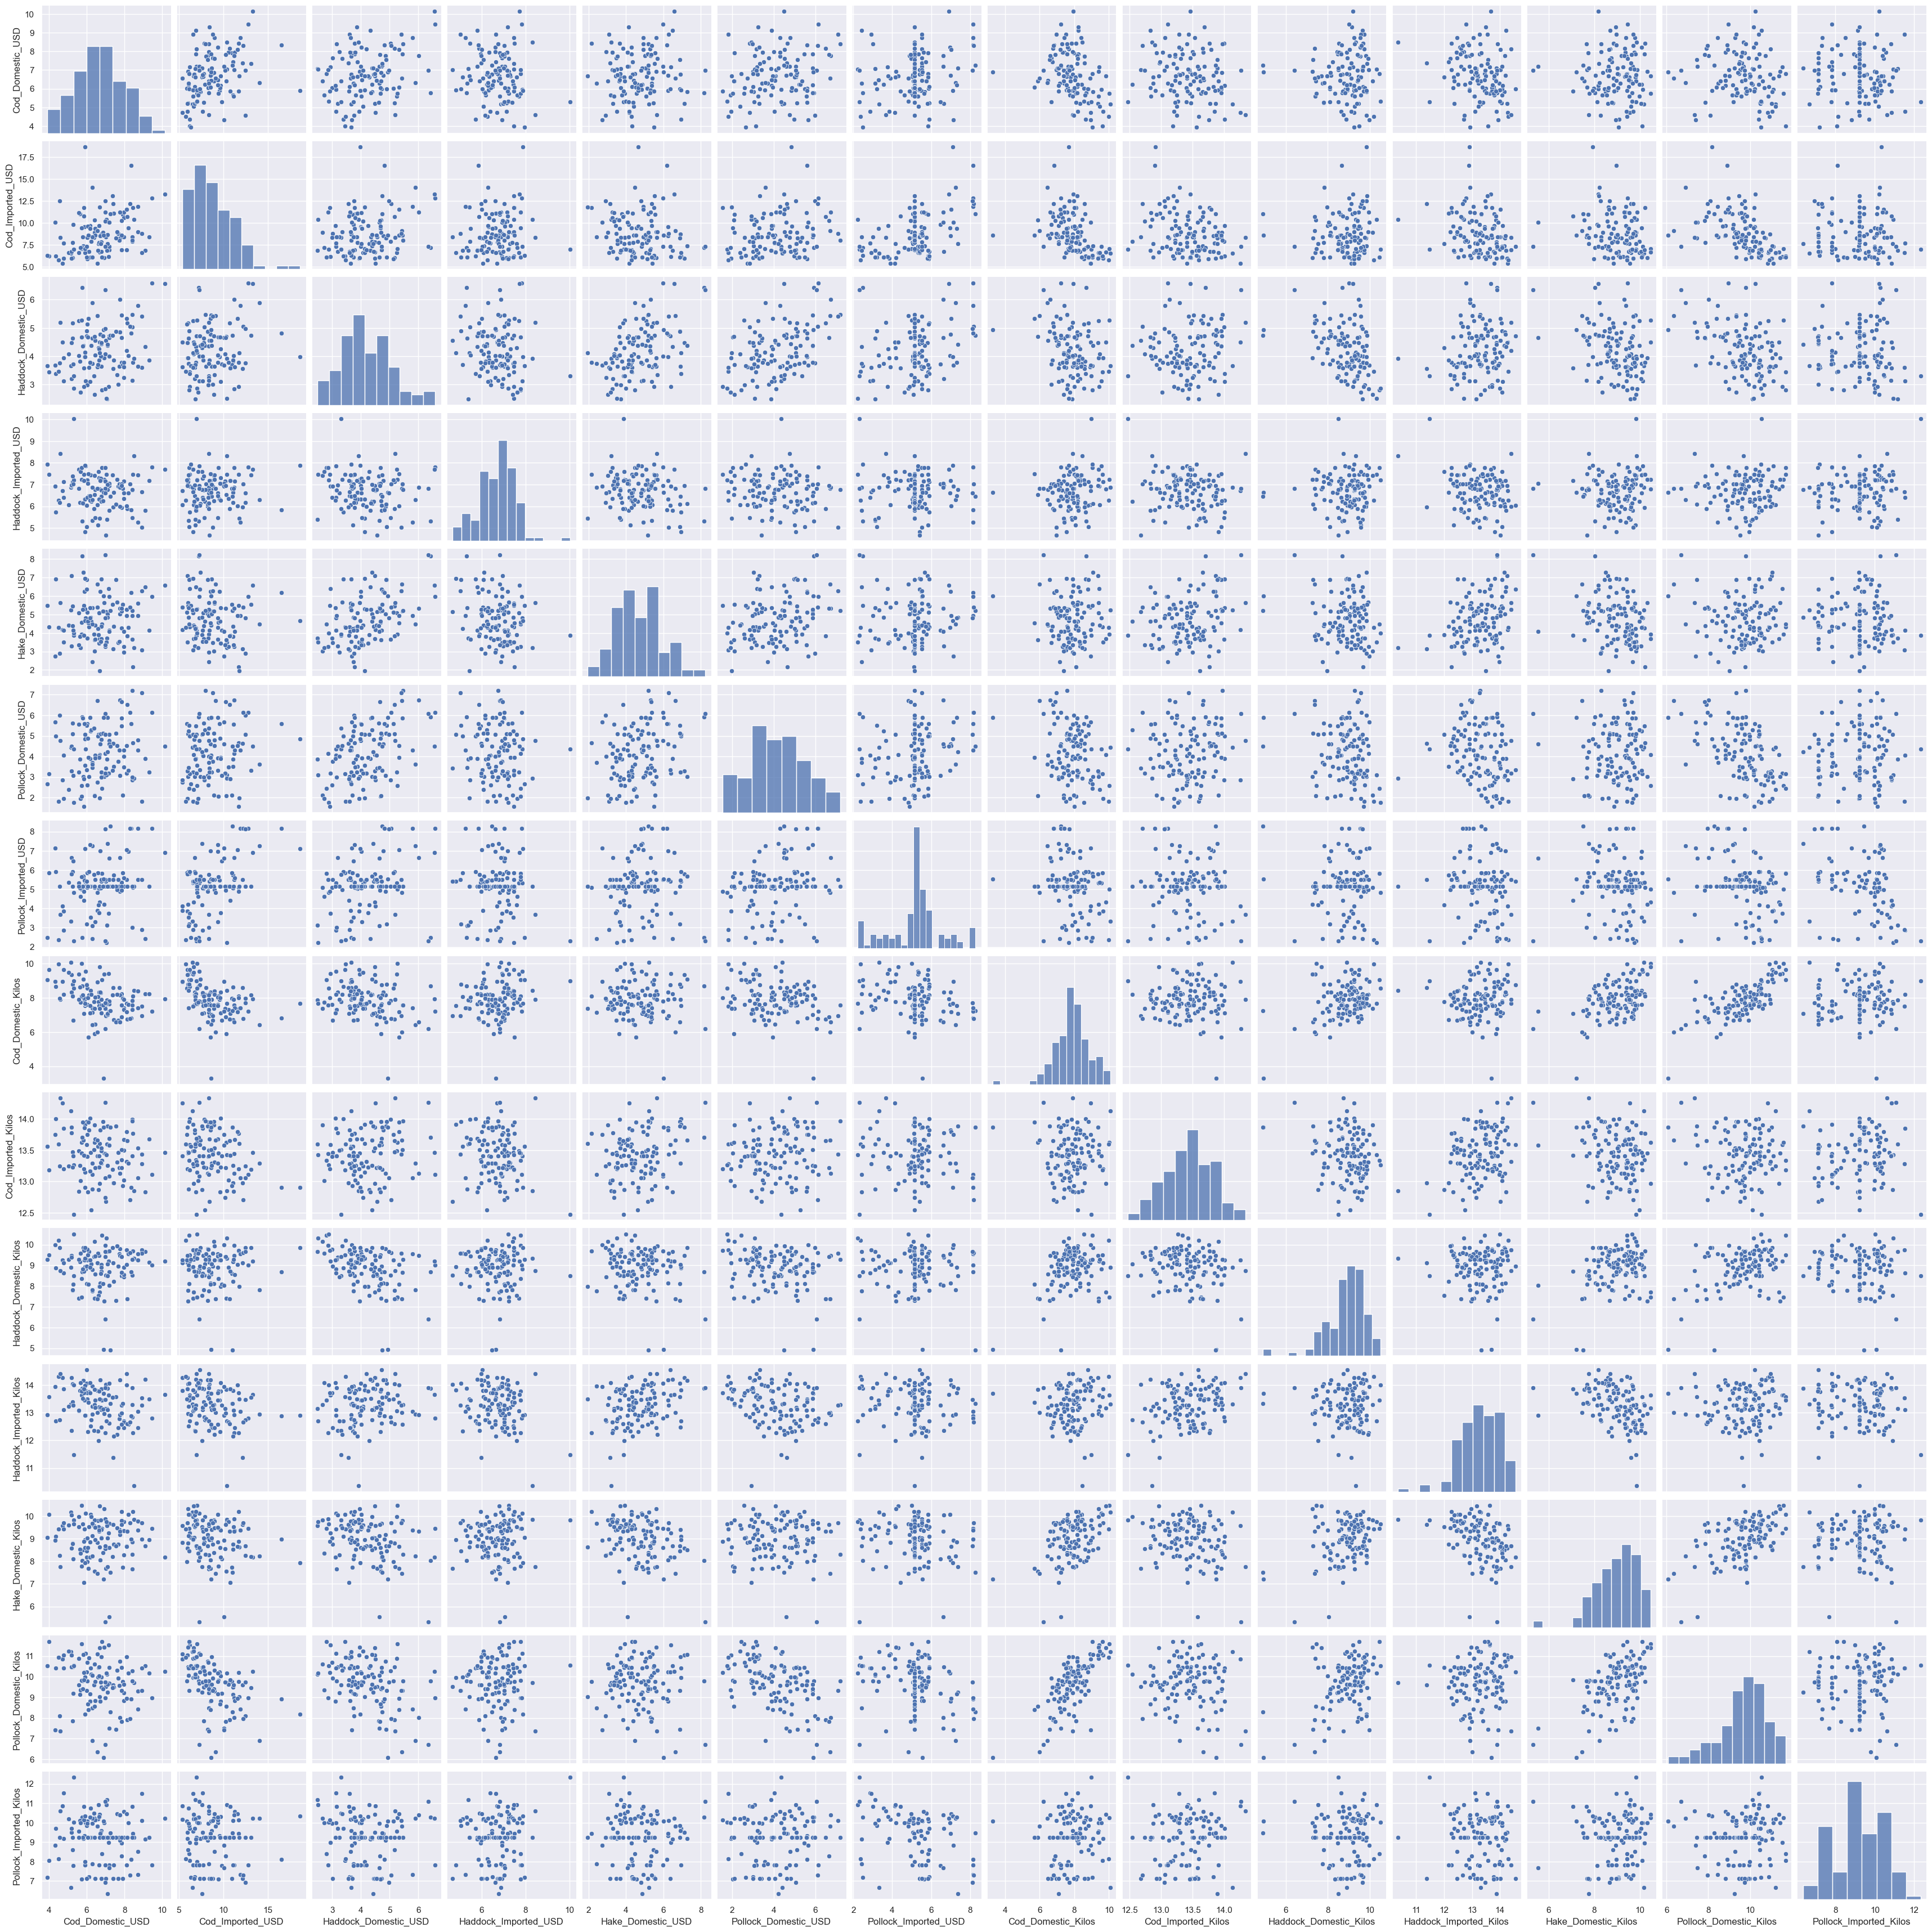

In [27]:
sns.pairplot(data=filtered_df_range)
plt.show();

In [79]:
filtered_df_range.head(10)

Cod_Domestic_USD  Cod_Imported_USD  Haddock_Domestic_USD  \
YYYY/MM                                                             
2014-01          6.564277          5.432189              3.632076   
2014-02          4.724613          5.419307              4.505383   
2014-03          4.780944          5.997028              3.940501   
2014-04          7.160816          6.205559              2.925727   
2014-05          5.588681          6.634645              5.245029   
...                   ...               ...                   ...   
2023-08          8.296003         12.221665              5.058450   
2023-09          7.832365         10.271607              4.656625   
2023-10          5.584164         11.177861              4.012876   
2023-11          6.185745          9.389704              3.788009   
2023-12          6.994718         12.500403              4.975382   

         Haddock_Imported_USD  Hake_Domestic_USD  Pollock_Domestic_USD  \
YYYY/MM                                                                  
2014-01              6.062704           5.390747              2.754788   
2014-02              6.705129           4.184428              2.851862   
2014-03              7.122593           3.514896              1.946293   
2014-04              6.930993           6.402688              3.191612   
2014-05              7.691731           5.082652              3.245136   
...                       ...                ...                   ...   
2023-08              7.029182           5.381039              6.132687   
2023-09              6.936796           5.330927              6.659265   
2023-10              6.809827           3.343172              5.567629   
2023-11              6.481896           4.816630              5.883270   
2023-12              6.607995           4.811291              5.062514   

         Pollock_Imported_USD  Cod_Domestic_Kilos  Cod_Imported_Kilos  \
YYYY/MM                                                                 
2014-01              3.902665            8.913566           13.410358   
2014-02              4.130382            8.955694           14.250250   
2014-03              3.855210            9.651675           13.204153   
2014-04              3.753865            9.437983           13.590067   
2014-05              5.323925            9.394194           13.488870   
...                       ...                 ...                 ...   
2023-08              8.177551            6.794218           12.702633   
2023-09              4.950753            6.890082           13.219132   
2023-10              5.148379            7.914942           12.842755   
2023-11              7.323531            7.559166           13.166541   
2023-12              8.124016            7.707455           13.053960   

         Haddock_Domestic_Kilos  Haddock_Imported_Kilos  Hake_Domestic_Kilos  \
YYYY/MM                                                                        
2014-01                9.123526               13.802386             8.829508   
2014-02                9.242380               14.268268             9.565663   
2014-03                9.114381               13.869506             9.692435   
2014-04                9.200760               13.639879             9.263849   
2014-05                7.413296               13.059289             9.984623   
...                         ...                     ...                  ...   
2023-08                9.601819               12.670740             9.707970   
2023-09                9.414184               12.984693             9.636803   
2023-10                9.273477               13.093808             9.533582   
2023-11                8.908427               13.727201             8.840992   
2023-12                9.648929               13.480594             8.675977   

         Pollock_Domestic_Kilos  Pollock_Imported_Kilos  
YYYY/MM                                                  
2014-01               11.101396          

# Feature Matrix and Target Vector

In [28]:
cols = filtered_df_range.columns
X_cols = cols.drop('Pollock_Domestic_USD')
X = filtered_df_range[X_cols]
y = filtered_df_range[['Pollock_Domestic_USD']]


# Regressions

In [29]:
#preprossesing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# models

# model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import mean_squared_error, r2_score

## Simple Linear Regression

### Imported Cod Price vs Domestic Pollock Price

Model score: 0.014658232554442763
Intercept: [2.79746395]
Coefficient: [[0.20791321]]
Mean Squared Error: 1.7832941584754682
R-squared: 0.014658232554442763


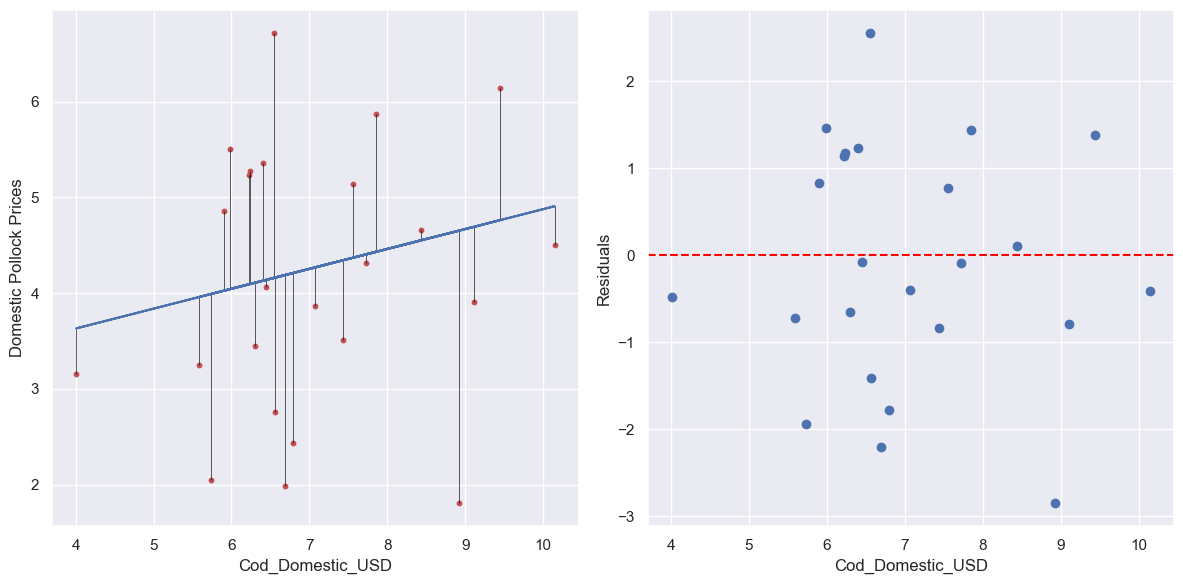

Model score: 0.05153296553624753
Intercept: [3.22287768]
Coefficient: [[0.10820955]]
Mean Squared Error: 1.716557419920002
R-squared: 0.05153296553624753


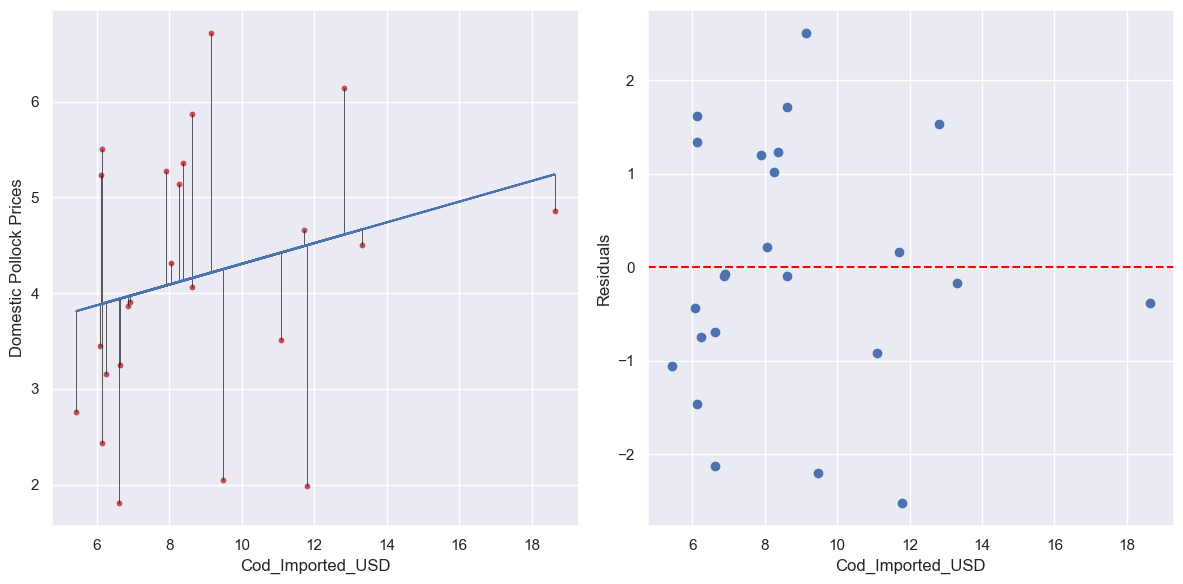

Model score: 0.18184720436929314
Intercept: [1.12313089]
Coefficient: [[0.72984965]]
Mean Squared Error: 1.4807117178956155
R-squared: 0.18184720436929314


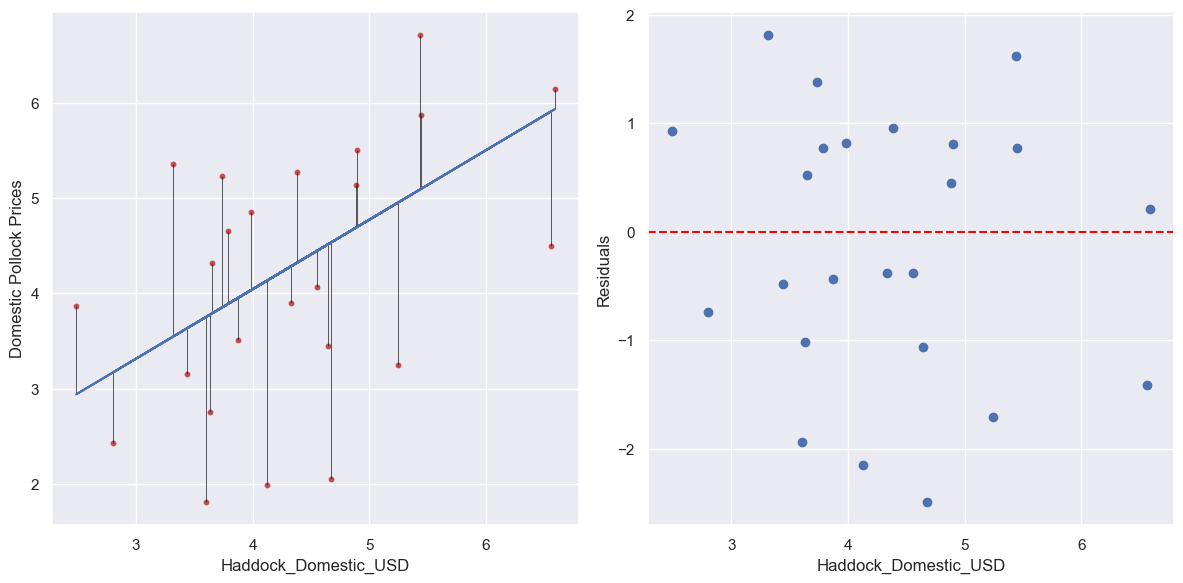

Model score: -0.04647120012053163
Intercept: [6.11320808]
Coefficient: [[-0.28965026]]
Mean Squared Error: 1.8939276095295206
R-squared: -0.04647120012053163


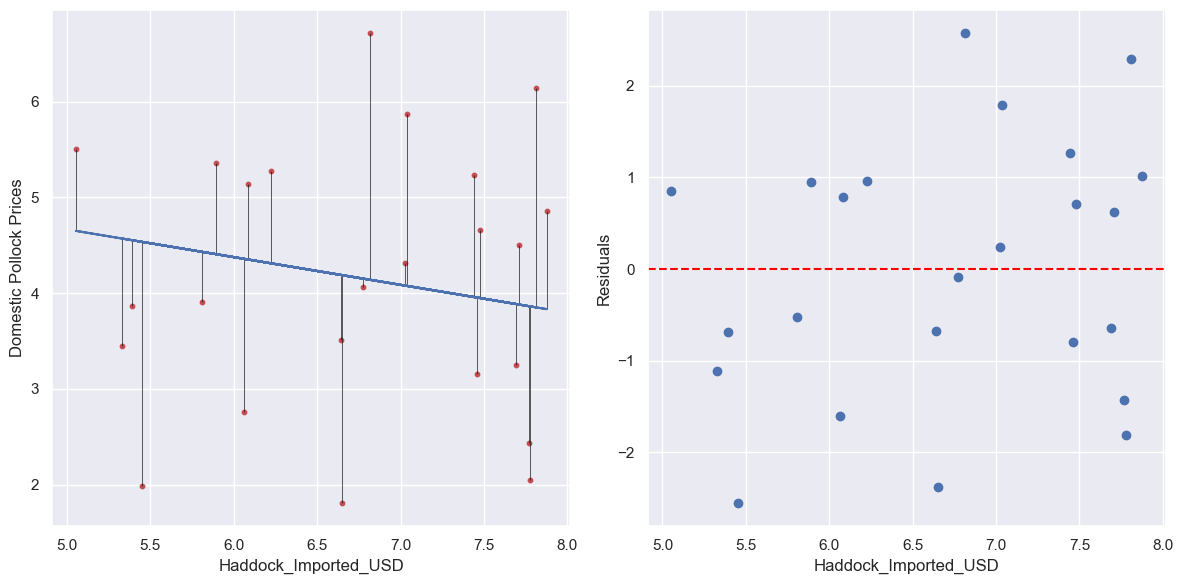

Model score: 0.18952449997618792
Intercept: [2.86563469]
Coefficient: [[0.27721463]]
Mean Squared Error: 1.4668171720020038
R-squared: 0.18952449997618792


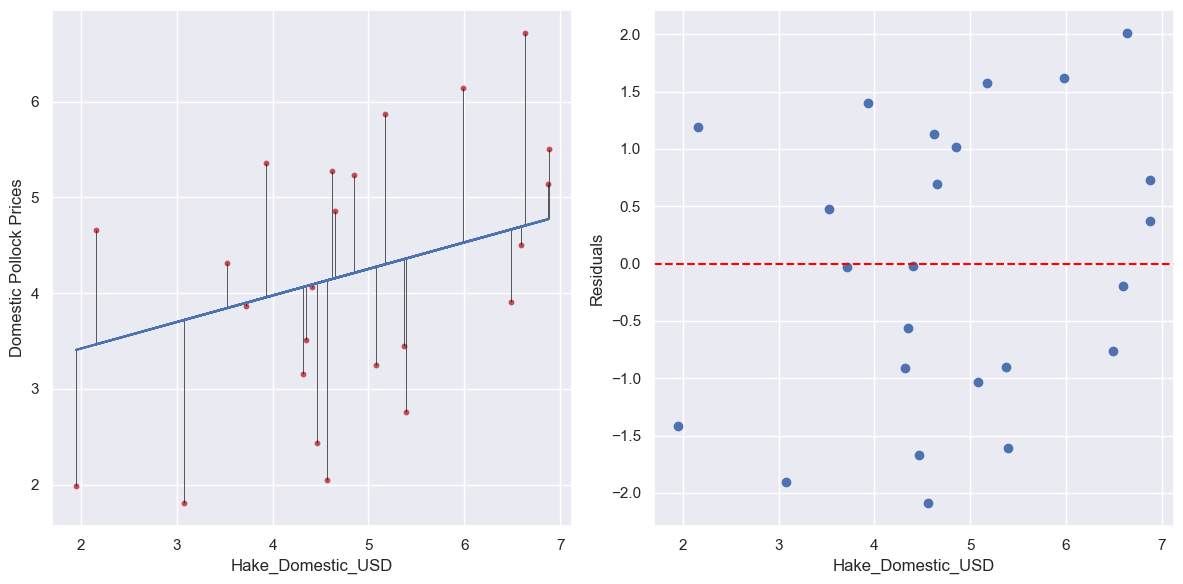

Model score: 0.045904004079241
Intercept: [2.93515616]
Coefficient: [[0.23728424]]
Mean Squared Error: 1.7267448436304438
R-squared: 0.045904004079241


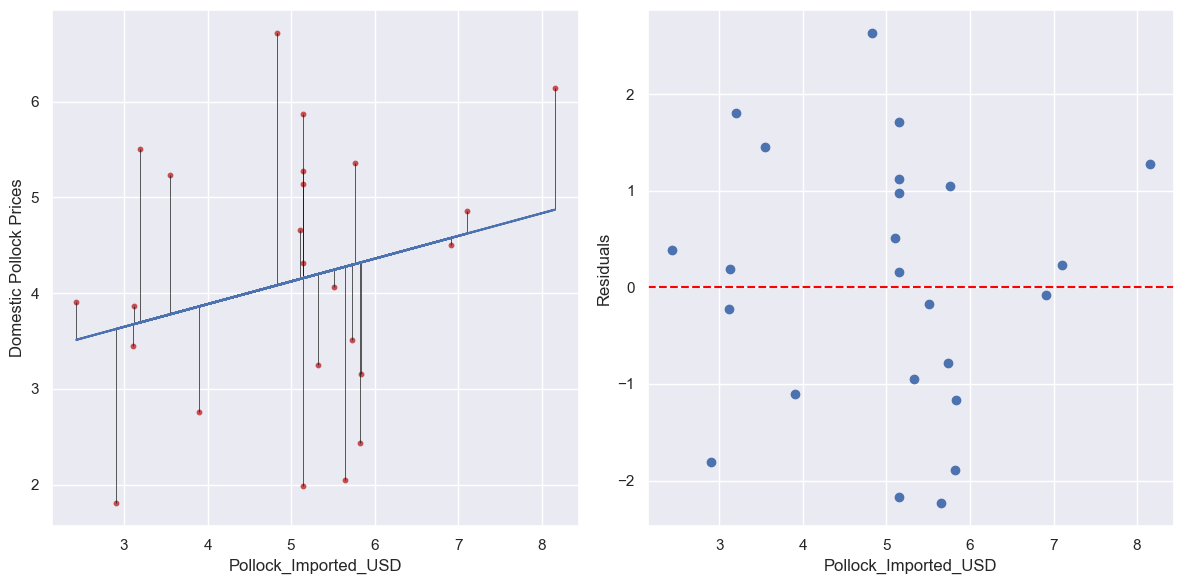

Model score: 0.10436211026968312
Intercept: [7.04158414]
Coefficient: [[-0.36367759]]
Mean Squared Error: 1.6209460205934267
R-squared: 0.10436211026968312


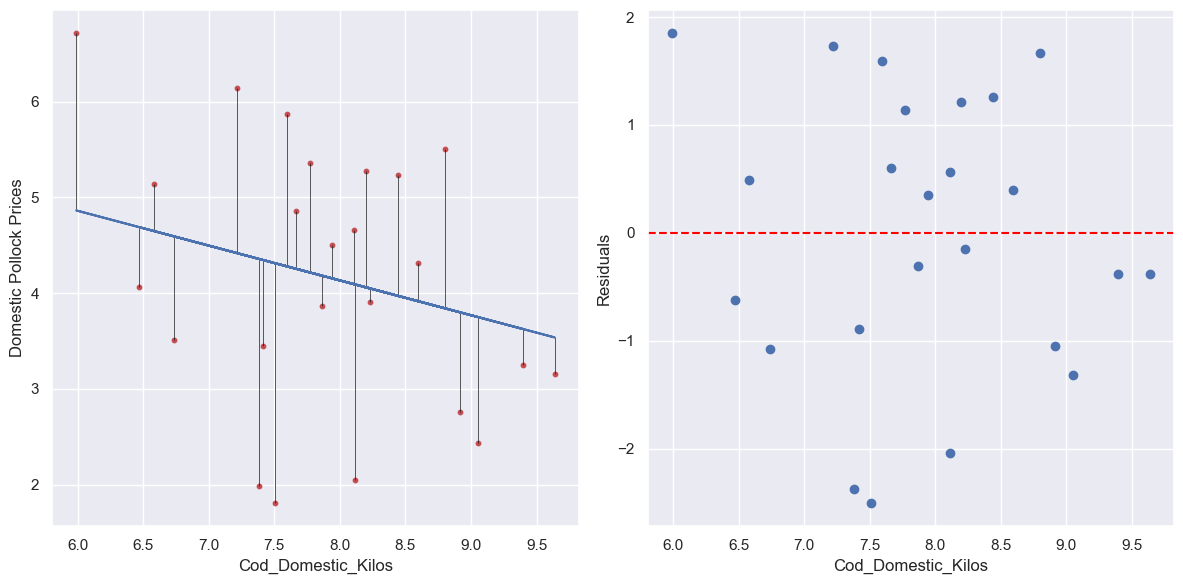

Model score: 0.01138546127848894
Intercept: [0.24343303]
Coefficient: [[0.2920878]]
Mean Squared Error: 1.7892172950878187
R-squared: 0.01138546127848894


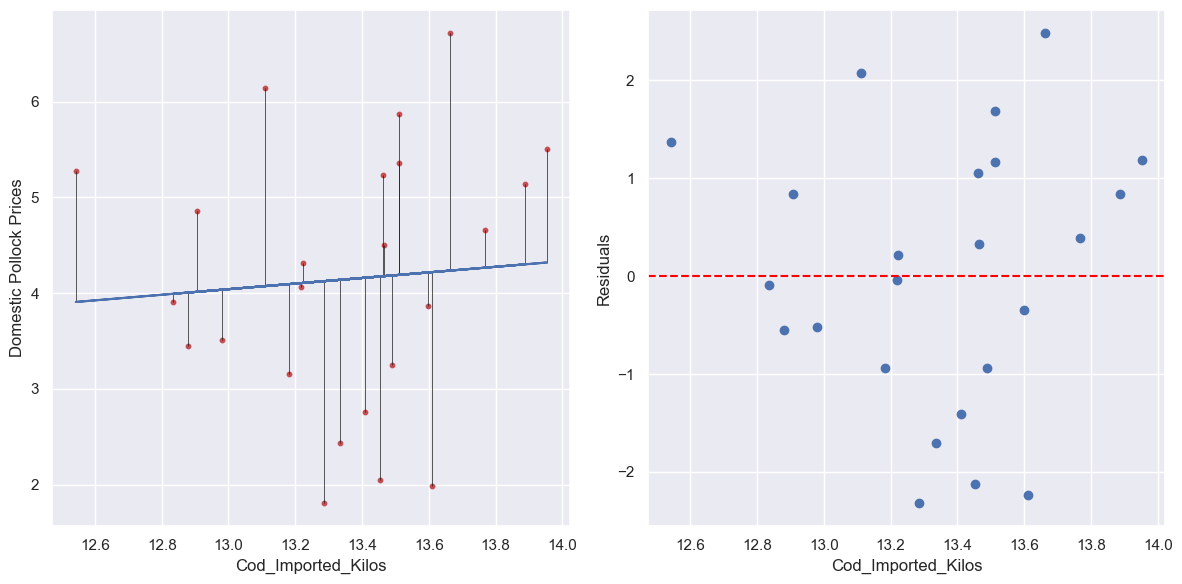

Model score: 0.039908904046318416
Intercept: [6.60949583]
Coefficient: [[-0.27419934]]
Mean Squared Error: 1.7375949133437196
R-squared: 0.039908904046318416


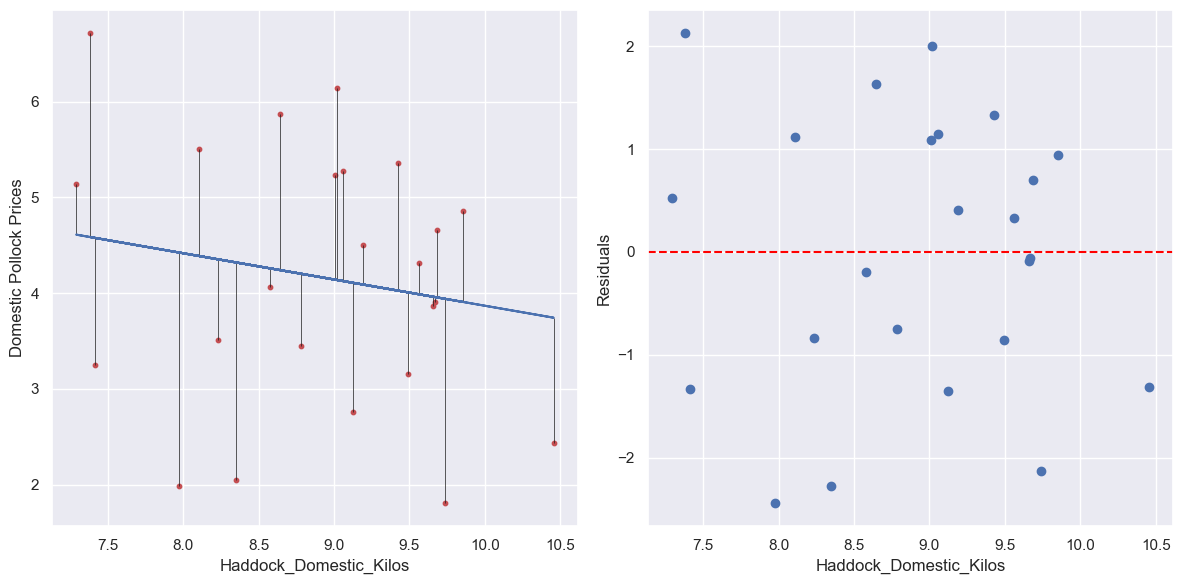

Model score: 0.10069555158994214
Intercept: [9.08441009]
Coefficient: [[-0.36944866]]
Mean Squared Error: 1.6275818426922306
R-squared: 0.10069555158994214


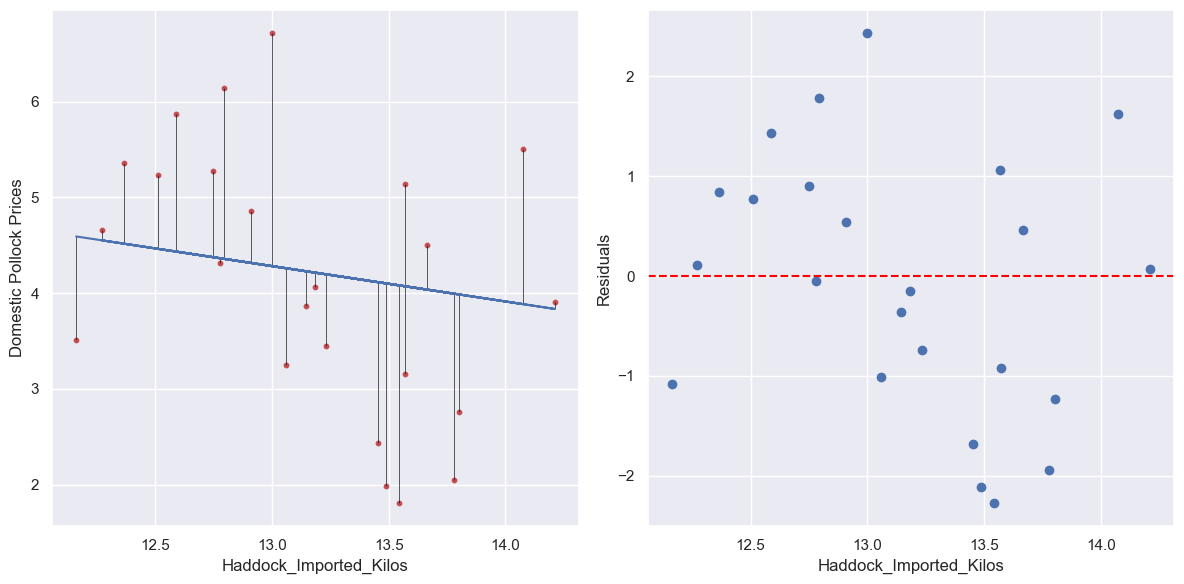

Model score: -0.0042047115669250346
Intercept: [4.83226595]
Coefficient: [[-0.07374067]]
Mean Squared Error: 1.8174327479219397
R-squared: -0.0042047115669250346


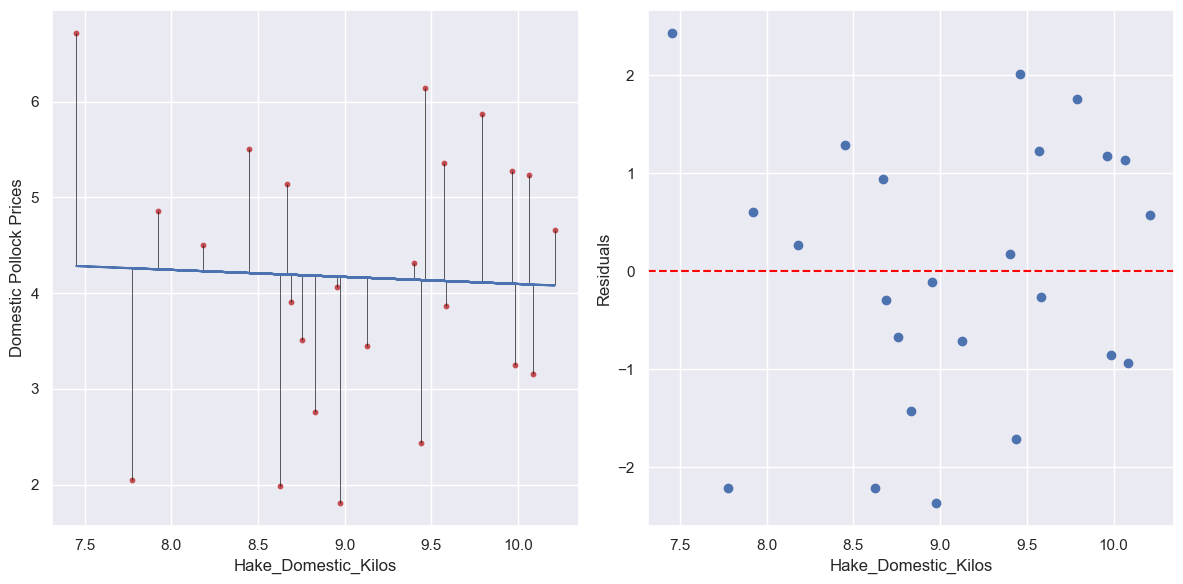

Model score: 0.3282930439271694
Intercept: [9.53703939]
Coefficient: [[-0.55573304]]
Mean Squared Error: 1.2156706744273897
R-squared: 0.3282930439271694


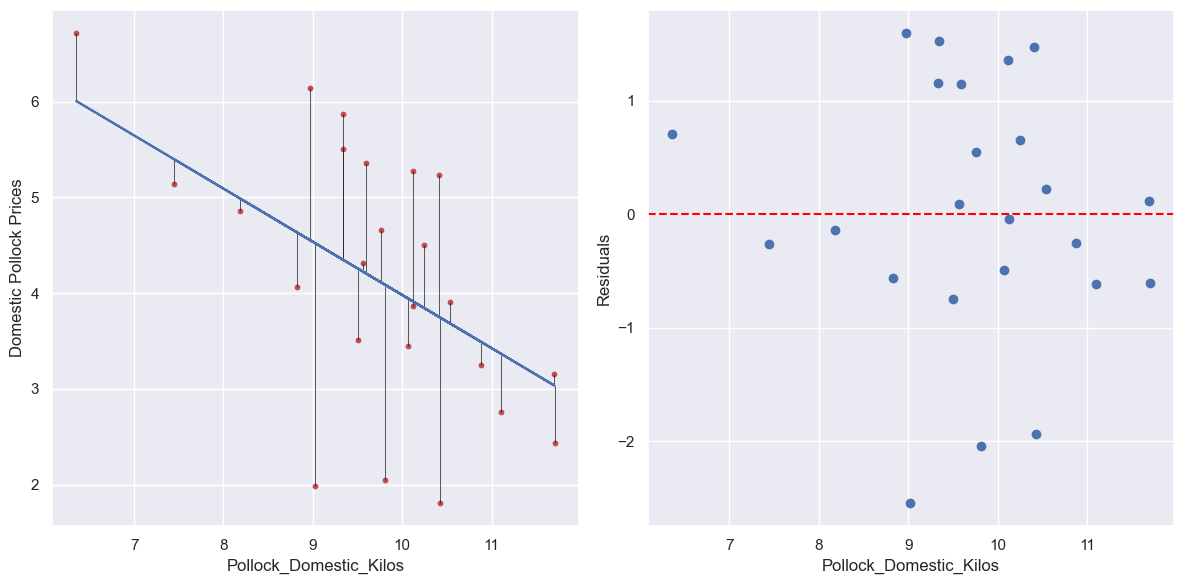

Model score: 0.0034542999793313323
Intercept: [3.97633453]
Coefficient: [[0.02144685]]
Mean Squared Error: 1.8035712929411531
R-squared: 0.0034542999793313323


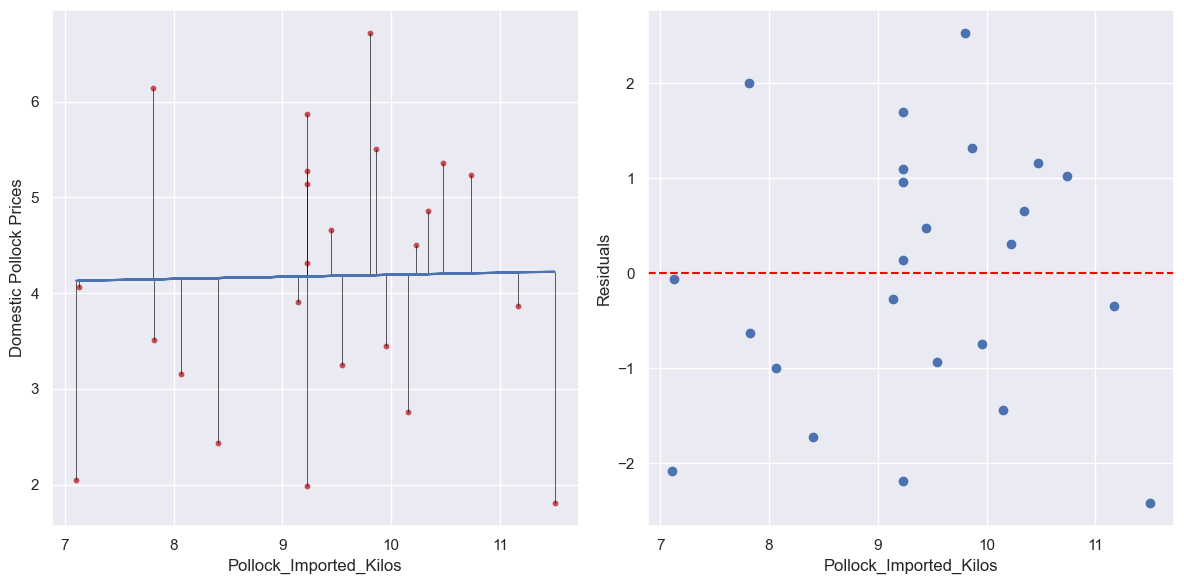

In [63]:
reg_dict_list = []

for col in X:

    X_simple = X[col].values.reshape(-1, 1)

    model = LinearRegression()

    X_train, X_test, y_train, y_test = train_test_split(X_simple, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    score = model.score(X_test, y_test)

    # Calculate and print coefficients
    print("Model score:", score)

    # Calculate and print the intercept and coef
    print("Intercept:", model.intercept_)
    print("Coefficient:", model.coef_)

    # Calculate and print the mean squared error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    r2 = r2_score(y_test, y_pred)
    print("R-squared:", r2)

    fig, ax = plt.subplots(1, 2)

    ax[0].vlines(X_test, ymin=y_test, ymax=y_pred, color='k', linewidth=.5)
    ax[0].scatter(X_test, y_test, c='r', s=10)
    ax[0].plot(X_test, y_pred, c='b')
    ax[0].set_ylabel('Domestic Pollock Prices')
    ax[0].set_xlabel(col)


    ax[1].scatter(X_test, residuals)
    ax[1].axhline(0, color='red', linestyle='--')  
    ax[1].set_ylabel('Residuals')
    ax[1].set_xlabel(col)

    plt.tight_layout()
    plt.show();

    reg_dict_list.append({
                            'Regressor': col,
                            'R-squared': r2,
                            'Mean Square Error': mse,
                            'Intercept': model.intercept_,
                            'Coefficient': model.coef_
                            })

results_df = pd.DataFrame(reg_dict_list)

In [71]:
results_df

Regressor  R-squared  Mean Square Error  \
0         Cod_Domestic_USD   0.014658           1.783294   
1         Cod_Imported_USD   0.051533           1.716557   
2     Haddock_Domestic_USD   0.181847           1.480712   
3     Haddock_Imported_USD  -0.046471           1.893928   
4        Hake_Domestic_USD   0.189524           1.466817   
5     Pollock_Imported_USD   0.045904           1.726745   
6       Cod_Domestic_Kilos   0.104362           1.620946   
7       Cod_Imported_Kilos   0.011385           1.789217   
8   Haddock_Domestic_Kilos   0.039909           1.737595   
9   Haddock_Imported_Kilos   0.100696           1.627582   
10     Hake_Domestic_Kilos  -0.004205           1.817433   
11  Pollock_Domestic_Kilos   0.328293           1.215671   
12  Pollock_Imported_Kilos   0.003454           1.803571   

                Intercept               Coefficient  
0    [2.7974639516141293]   [[0.20791321031647433]]  
1    [3.2228776844893883]   [[0.10820954514523101]]  
2     [1.123130885757559]    [[0.7298496464313005]]  
3    [6.1132080770820485]  [[-0.28965025629632124]]  
4    [2.8656346881604375]    [[0.2772146257896572]]  
5    [2.9351561572636733]   [[0.23728423549204644]]  
6     [7.041584144561278]   [[-0.3636775861700663]]  
7   [0.24343303411504458]   [[0.29208779788174466]]  
8     [6.609495825889223]  [[-0.27419933747801645]]  
9     [9.084410090559562]   [[-0.3694486649314879]]  
10    [4.832265948643271]  [[-0.07374066505489141]]  
11    [9.537039391301104]   [[-0.5557330369289881]]  
12   [3.9763345303467306]  [[0.021446851839973406]]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


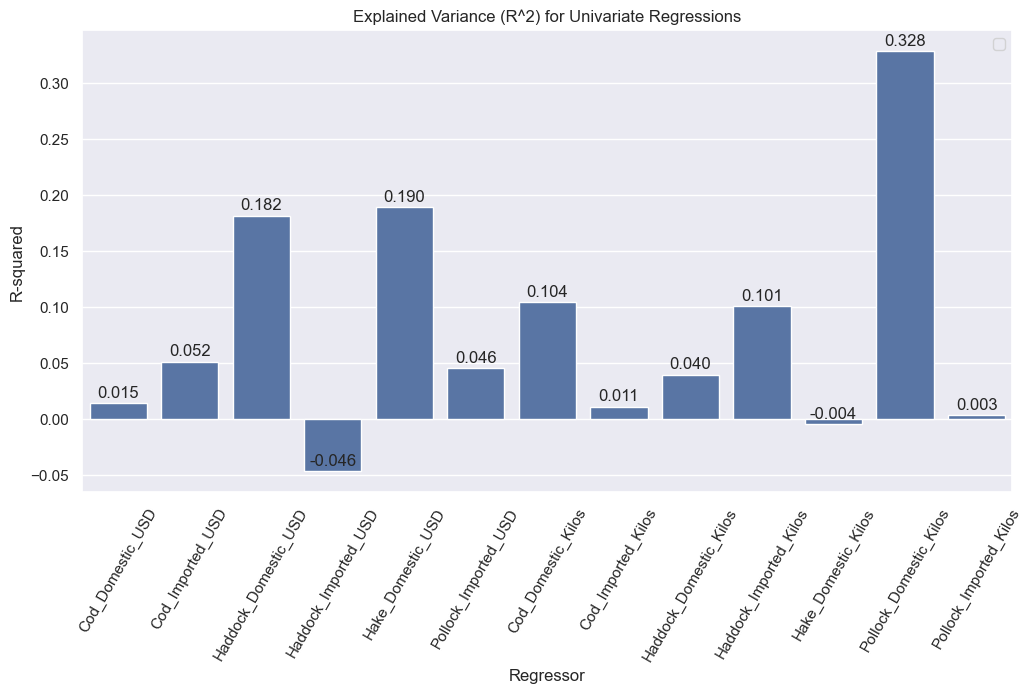

In [78]:

sns.barplot(data=results_df, x='Regressor', y='R-squared')
for i, value in enumerate(results_df['R-squared'].values):
    plt.text(i, (value + 0.005), '{:.3f}'.format(value), ha='center')
plt.title(r'Explained Variance (R^2) for Univariate Regressions')
plt.xticks(rotation=60)
plt.legend()
plt.show()

In [75]:
X_simple = X[['Cod_Imported_USD']]

model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X_simple, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
residuals = y_test - y_pred

score = model.score(X_test, y_test)

# Calculate and print coefficients
print("Model score:", score)

# Calculate and print the intercept
print("Intercept:", model.intercept_)

# Calculate and print the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Model score: 0.05153296553624753
Intercept: [3.22287768]
Mean Squared Error: 1.716557419920002
R-squared: 0.05153296553624753


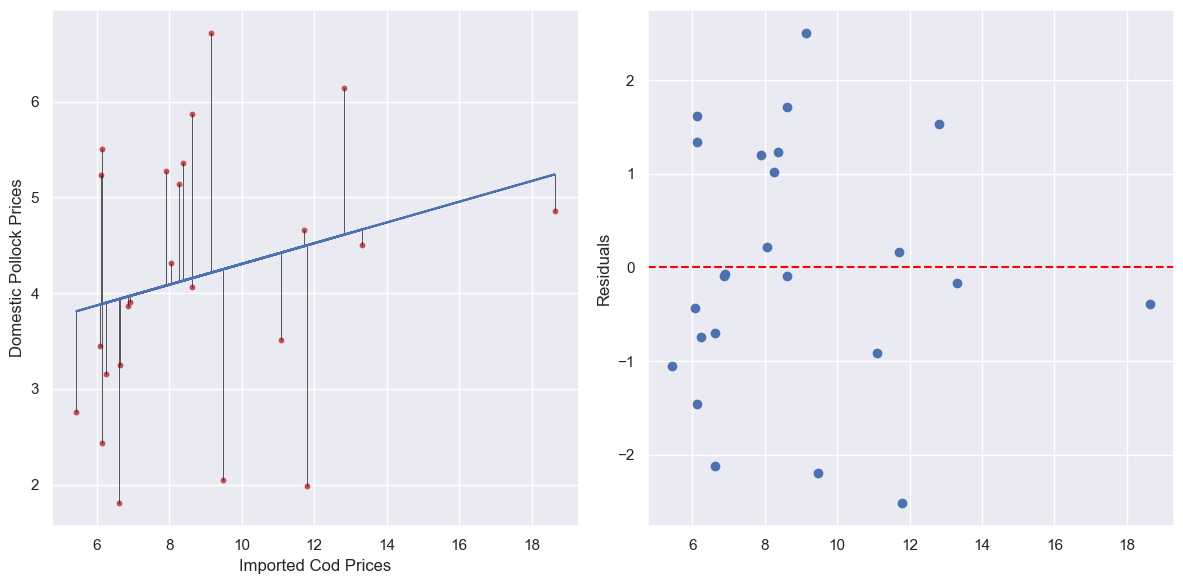

In [31]:
# plot regression and residuals

fig, ax = plt.subplots(1, 2)

ax[0].vlines(X_test, ymin=y_test, ymax=y_pred, color='k', linewidth=.5)
ax[0].scatter(X_test, y_test, c='r', s=10)
ax[0].plot(X_test, y_pred, c='b')
ax[0].set_ylabel('Domestic Pollock Prices')
ax[0].set_xlabel('Imported Cod Prices')


ax[1].scatter(X_test, residuals)
ax[1].axhline(0, color='red', linestyle='--')  
ax[1].set_ylabel('Residuals')
ax[1].set_xlabel('')

plt.tight_layout()
plt.show();

In [32]:
import statsmodels.api as sm

X_statsmodel = sm.add_constant(X_simple) 
statsmodel = sm.OLS(y.values, X_statsmodel).fit()  

# results
print(statsmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.190
Date:                Sat, 13 Apr 2024   Prob (F-statistic):             0.0429
Time:                        12:34:28   Log-Likelihood:                -201.16
No. Observations:                 120   AIC:                             406.3
Df Residuals:                     118   BIC:                             411.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.2420      0.469  

## Multi LinearRegression

### Scaling

In [33]:

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

### Check Statsmodel for Linear Regression fit data

In [34]:
import statsmodels.api as sm

X_statsmodel = sm.add_constant(X_scaled) 
statsmodel = sm.OLS(y.values, X_statsmodel).fit()  

# results
print(statsmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     11.40
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           6.03e-15
Time:                        12:34:28   Log-Likelihood:                -150.79
No. Observations:                 120   AIC:                             329.6
Df Residuals:                     106   BIC:                             368.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4

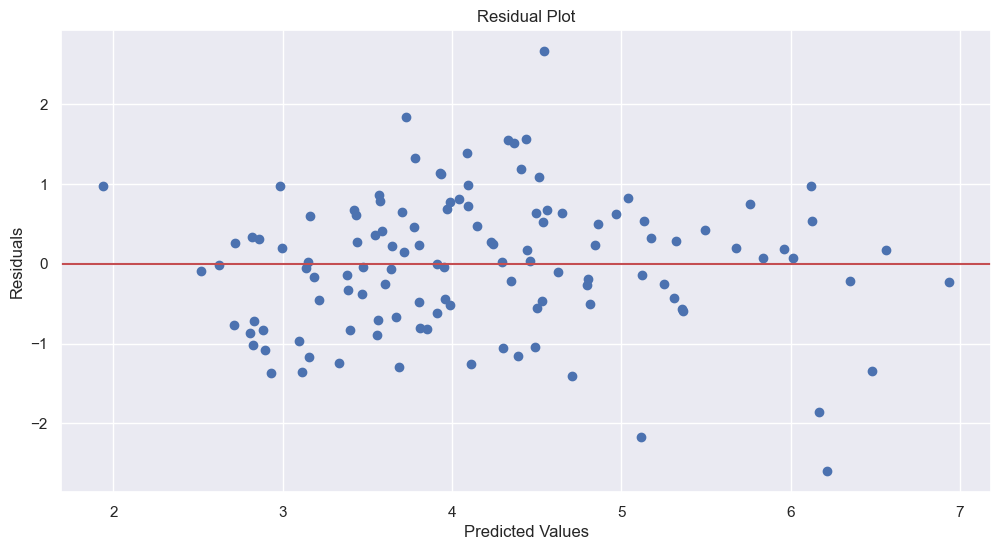

In [35]:
# get residuals
residuals = statsmodel.resid


# Plot residuals against predicted values
plt.scatter(statsmodel.fittedvalues, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')  
plt.show()

### Multi Linear Regression

Model score: 0.6576131321044945
Intercept: [4.20315562]
Mean Squared Error: 0.6196596162158555
R-squared: 0.6576131321044945
                        Coefficients
Cod_Domestic_USD            0.019500
Cod_Imported_USD           -0.354486
Haddock_Domestic_USD        0.301760
Haddock_Imported_USD       -0.185485
Hake_Domestic_USD           0.377658
Pollock_Imported_USD        0.114931
Cod_Domestic_Kilos          0.074949
Cod_Imported_Kilos          0.034877
Haddock_Domestic_Kilos      0.078606
Haddock_Imported_Kilos     -0.357981
Hake_Domestic_Kilos         0.417502
Pollock_Domestic_Kilos     -0.967561
Pollock_Imported_Kilos      0.081525


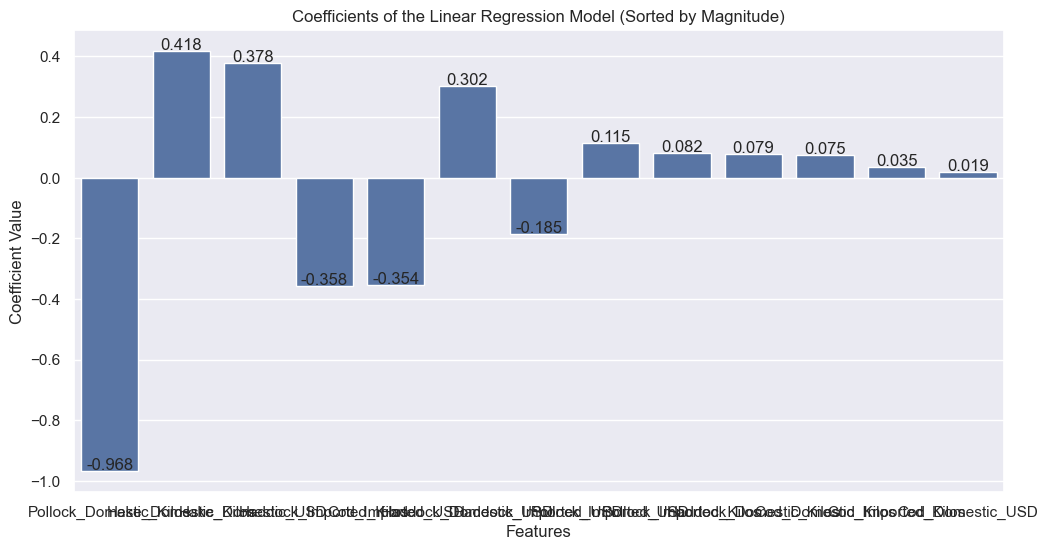

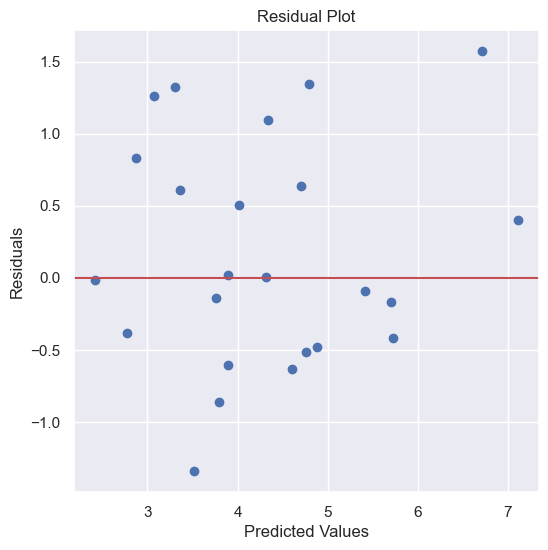

In [48]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
residuals = y_test - y_pred

score = model.score(X_test, y_test)
# evaluate 
print("Model score:", score)
print("Intercept:", model.intercept_)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# get coef dataframe
coef_df = pd.DataFrame(model.coef_.ravel(), X.columns, columns=['Coefficients'])
print(coef_df)

# plot coef magnitudes
coef_df['Abs_Coefficients'] = coef_df['Coefficients'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficients', ascending=False)
#sorted_coef_df['Coefficients'].plot(kind='bar', legend=False)
sns.barplot(sorted_coef_df['Coefficients'])
for i, value in enumerate(sorted_coef_df['Coefficients'].values):
    plt.text(i, (value + 0.005), '{:.3f}'.format(value), ha='center')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of the Linear Regression Model (Sorted by Magnitude)')
plt.show()

# get residuals
residuals = y_pred - y_test

# Plot residuals against predicted values
plt.figure(figsize=(6,6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')  
plt.show()


# Multi Linear Regression with PCA 

Model score: 0.6639009280337453
Intercept: [4.17308738]
Mean Squared Error: 0.6698847988735818
R-squared: 0.6298616980435273
Best Parameters: {'pca__n_components': 11}
Explained Variance Ratios
    n_components  Percentage of Explained Variance
0              1                          0.253358
1              2                          0.183789
2              3                          0.126438
3              4                          0.081966
4              5                          0.061525
5              6                          0.059535
6              7                          0.052895
7              8                          0.049672
8              9                          0.037149
9             10                          0.033980
10            11                          0.025509


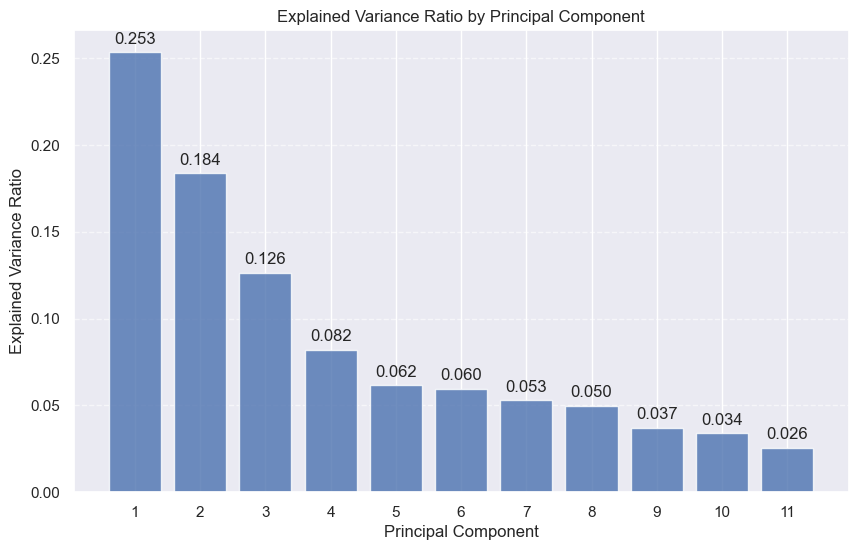

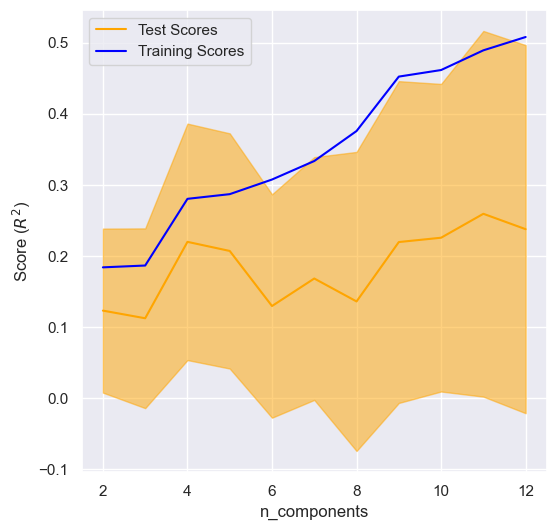

In [44]:

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a pipe
pipeline = Pipeline([
    ('pca', PCA()),
    ('regression', LinearRegression())
])

# PCA values for gridsearch
param_grid = {
    'pca__n_components': np.arange(2, X.shape[1])  # Specify the range of n_components to search over
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Predict on the test data using the best model
y_pred = best_model.predict(X_test)
residuals = y_test-y_pred

# Get results dict
results_df = pd.DataFrame(grid_search.cv_results_)

# Evaluate
print("Model score:", score)
print("Intercept:", best_model.named_steps['regression'].intercept_)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
print("Best Parameters:", grid_search.best_params_)

# explained variance
best_pca = best_model.named_steps['pca']
explained_variance_ratio = best_pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame({
    'n_components': np.arange(1, len(explained_variance_ratio) + 1),
    'Percentage of Explained Variance': explained_variance_ratio
})
print('Explained Variance Ratios')
print(explained_variance_df)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8)
for i, value in enumerate(explained_variance_ratio):
    plt.text(i+1, (abs(value) + 0.005), '{:.3f}'.format(value), ha='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# plot text train scores
plt.figure(figsize=(6,6))
plt.plot(results_df['param_pca__n_components'], results_df[['mean_test_score']], label='Test Scores', c='orange')
plt.plot(results_df['param_pca__n_components'], results_df[['mean_train_score']], label='Training Scores', c='blue')
plt.fill_between(x=results_df['param_pca__n_components'].astype(float), 
                 y1=results_df['mean_test_score'] + results_df['std_test_score'], 
                 y2=results_df['mean_test_score'] - results_df['std_test_score'], 
                 color='orange', alpha=0.5)
plt.xlabel('n_components')
plt.ylabel(r'Score ($R^2$)')
plt.legend()
plt.show();

## Ridge Regression (Naive, alpha=1)

Model score: 0.6639009280337453
Intercept: [4.20253091]
Mean Squared Error: 0.6082798187478279
R-squared: 0.6639009280337453
                        Coefficients
Cod_Domestic_USD            0.014681
Cod_Imported_USD           -0.330379
Haddock_Domestic_USD        0.308581
Haddock_Imported_USD       -0.179152
Hake_Domestic_USD           0.368584
Pollock_Imported_USD        0.112243
Cod_Domestic_Kilos          0.061481
Cod_Imported_Kilos          0.040372
Haddock_Domestic_Kilos      0.073792
Haddock_Imported_Kilos     -0.354874
Hake_Domestic_Kilos         0.404638
Pollock_Domestic_Kilos     -0.925417
Pollock_Imported_Kilos      0.078535


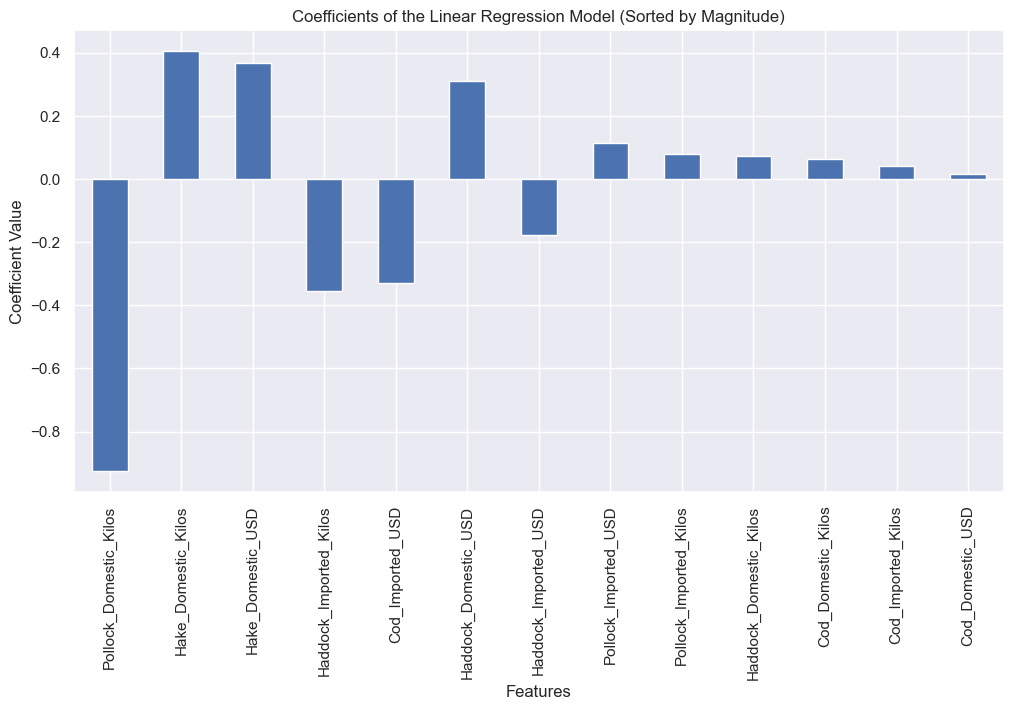

In [38]:
from sklearn.linear_model import Ridge

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

ridge_model = Ridge(alpha=1.0)

# Fit the model to the training data
ridge_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = ridge_model.predict(X_test)
residuals = y_test - y_pred

# Evaluate
score = ridge_model.score(X_test, y_test)
print("Model score:", score)
print("Intercept:", ridge_model.intercept_)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# make coef dataframe
coef_df = pd.DataFrame(ridge_model.coef_.ravel(), X.columns, columns=['Coefficients'])
print(coef_df)


# plot coefs
coef_df['Abs_Coefficients'] = coef_df['Coefficients'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficients', ascending=False)
sorted_coef_df['Coefficients'].plot(kind='bar', legend=False)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of the Linear Regression Model (Sorted by Magnitude)')
plt.show()

## Ridge Regression with Gridsearch over alphas

Best alpha: 15.24695727017573
Mean Squared Error with best alpha: 0.6265390413045866
R-squared: 0.6538119729722656
                        Coefficients
Cod_Domestic_USD            0.001106
Cod_Imported_USD           -0.151116
Haddock_Domestic_USD        0.324526
Haddock_Imported_USD       -0.132358
Hake_Domestic_USD           0.285385
Pollock_Imported_USD        0.096276
Cod_Domestic_Kilos         -0.020943
Cod_Imported_Kilos          0.069850
Haddock_Domestic_Kilos      0.025279
Haddock_Imported_Kilos     -0.305798
Hake_Domestic_Kilos         0.282372
Pollock_Domestic_Kilos     -0.601100
Pollock_Imported_Kilos      0.058831


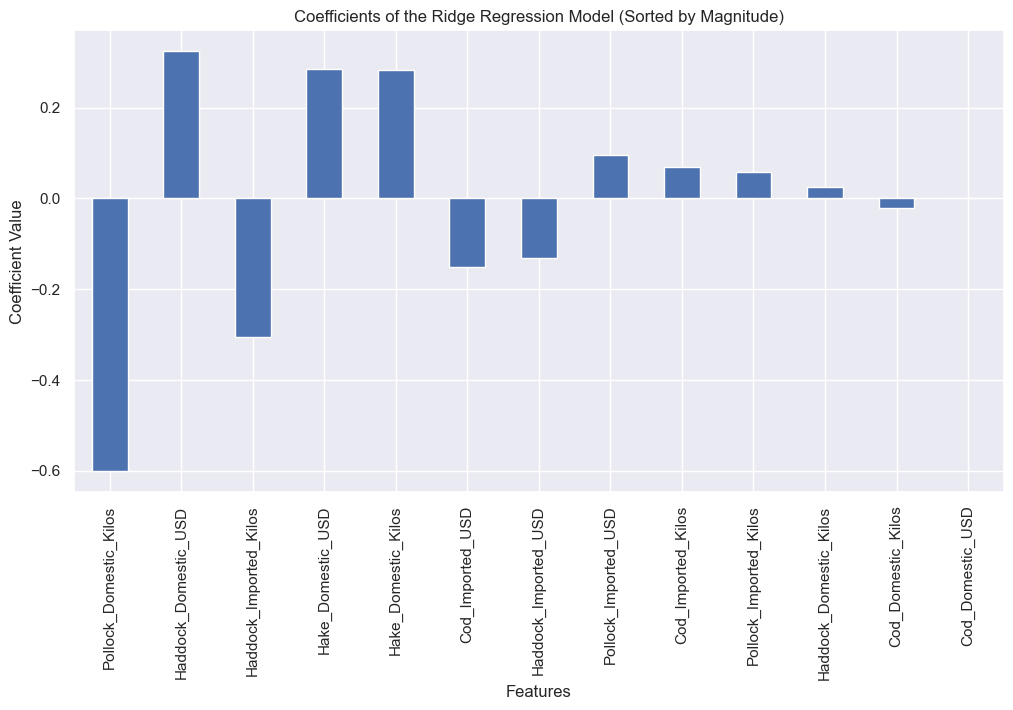

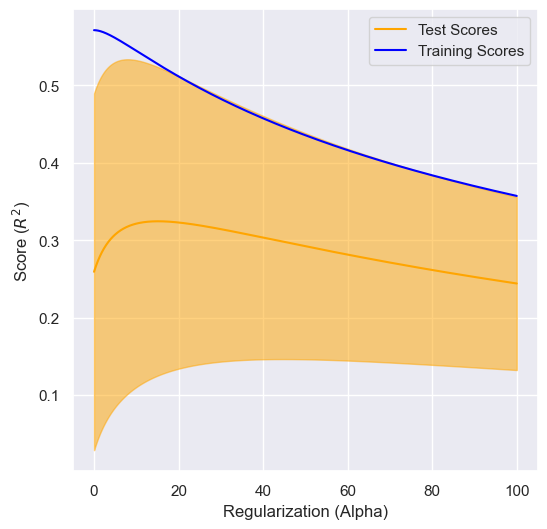

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the model
ridge = Ridge()

# Params for gridsearch
alphas = np.logspace(-4, 2, 1000)

# Define the grid search with cross-validation
grid = GridSearchCV(estimator=ridge, param_grid={'alpha': alphas}, scoring='r2', cv=5, return_train_score=True)

# Fit the grid search to the data
grid.fit(X_train, y_train)

# Get the best alpha
best_alpha = grid.best_params_['alpha']
print("Best alpha:", best_alpha)

# Refit the Ridge model with the best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)

# Get results dict
results_df = pd.DataFrame(grid.cv_results_)

# Evaluate the model
y_pred = ridge_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error with best alpha:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

coef_df = pd.DataFrame(ridge_best.coef_.ravel(), X.columns, columns=['Coefficients'])
print(coef_df)

coef_df['Abs_Coefficients'] = coef_df['Coefficients'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficients', ascending=False)
sorted_coef_df['Coefficients'].plot(kind='bar', legend=False)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of the Ridge Regression Model (Sorted by Magnitude)')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(results_df['param_alpha'], results_df[['mean_test_score']], label='Test Scores', c='orange')
plt.plot(results_df['param_alpha'], results_df[['mean_train_score']], label='Training Scores', c='blue')
plt.fill_between(x=results_df['param_alpha'].astype(float), 
                 y1=results_df['mean_test_score'] + results_df['std_test_score'], 
                 y2=results_df['mean_test_score'] - results_df['std_test_score'], 
                 color='orange', alpha=0.5)
plt.xlabel('Regularization (Alpha)')
plt.ylabel(r'Score ($R^2$)')
plt.legend()
plt.show();


## Lasso Regression

Best alpha: 0.046415888336127774
Mean Squared Error with best alpha: 0.6190350818451096
R-squared: 0.6579582124703873
                        Coefficients
Cod_Domestic_USD            0.019250
Cod_Imported_USD           -0.353303
Haddock_Domestic_USD        0.302114
Haddock_Imported_USD       -0.185173
Hake_Domestic_USD           0.377221
Pollock_Imported_USD        0.114796
Cod_Domestic_Kilos          0.074276
Cod_Imported_Kilos          0.035153
Haddock_Domestic_Kilos      0.078378
Haddock_Imported_Kilos     -0.357841
Hake_Domestic_Kilos         0.416885
Pollock_Domestic_Kilos     -0.965495
Pollock_Imported_Kilos      0.081376


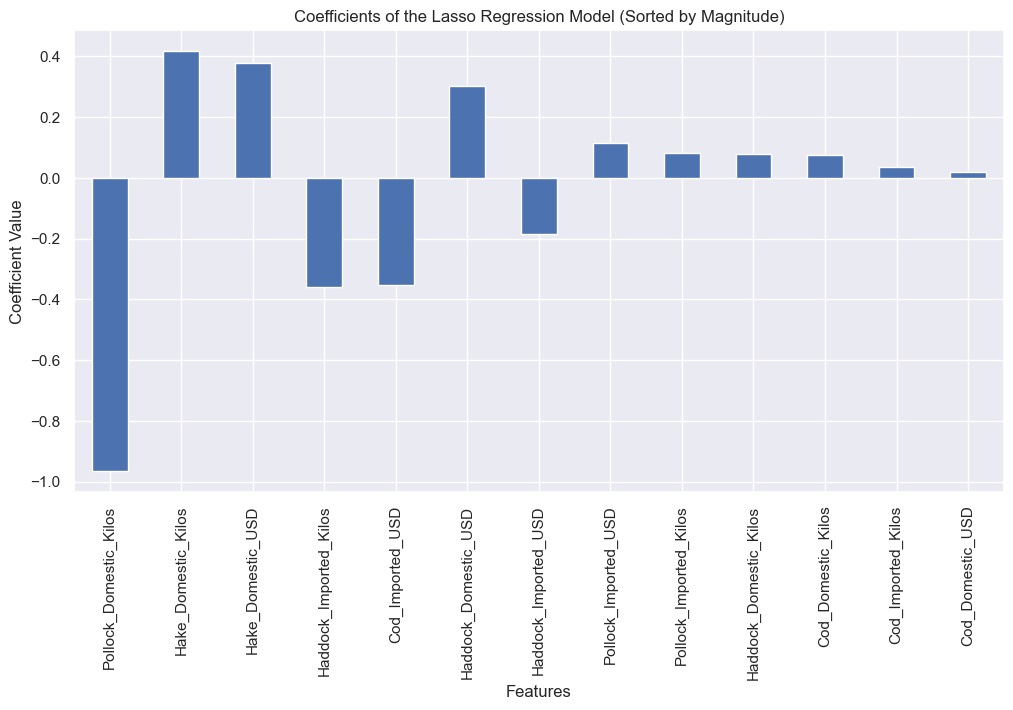

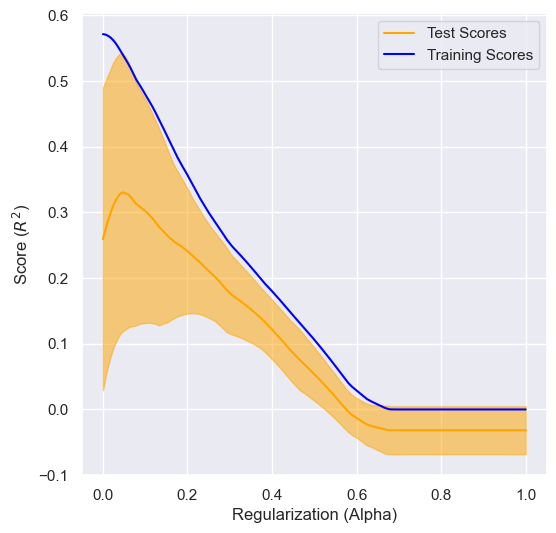

In [40]:

from sklearn.linear_model import Lasso

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the model
lasso = Lasso()

# Params for gridsearch
alphas = np.logspace(-4, 0, 1000)

# Define the grid search with cross-validation
grid = GridSearchCV(estimator=lasso, param_grid={'alpha': alphas}, scoring='r2', cv=5, return_train_score=True)

# Fit the grid search to the data
grid.fit(X_train, y_train)

# Get the best alpha
best_alpha = grid.best_params_['alpha']
print("Best alpha:", best_alpha)

# Refit the Ridge model with the best alpha
lasso_best = Ridge(alpha=best_alpha)
lasso_best.fit(X_train, y_train)

# Get results dict
results_df = pd.DataFrame(grid.cv_results_)

# Evaluate the model
y_pred = lasso_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error with best alpha:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# coef dataframe
coef_df = pd.DataFrame(lasso_best.coef_.ravel(), X.columns, columns=['Coefficients'])
print(coef_df)

# plot coefficient magnitude
coef_df['Abs_Coefficients'] = coef_df['Coefficients'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficients', ascending=False)
sorted_coef_df['Coefficients'].plot(kind='bar', legend=False)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of the Lasso Regression Model (Sorted by Magnitude)')
plt.show()

# plot train vs test score
plt.figure(figsize=(6,6))
plt.plot(results_df['param_alpha'], results_df[['mean_test_score']], label='Test Scores', c='orange')
plt.plot(results_df['param_alpha'], results_df[['mean_train_score']], label='Training Scores', c='blue')
plt.fill_between(x=results_df['param_alpha'].astype(float), 
                 y1=results_df['mean_test_score'] + results_df['std_test_score'], 
                 y2=results_df['mean_test_score'] - results_df['std_test_score'], 
                 color='orange', alpha=0.5)
plt.xlabel('Regularization (Alpha)')
plt.ylabel(r'Score ($R^2$)')
#plt.ylim(0, 2.5)
plt.legend()
plt.show();


Computing regularization path using the LARS ...
.Coefficient Order:
['Pollock_Domestic_Kilos', 'Haddock_Domestic_USD', 'Haddock_Imported_Kilos', 'Hake_Domestic_USD', 'Hake_Domestic_Kilos', 'Haddock_Imported_USD', 'Cod_Imported_Kilos', 'Cod_Imported_USD', 'Pollock_Imported_USD', 'Pollock_Imported_Kilos', 'Haddock_Domestic_Kilos', 'Cod_Domestic_Kilos', 'Cod_Domestic_USD']


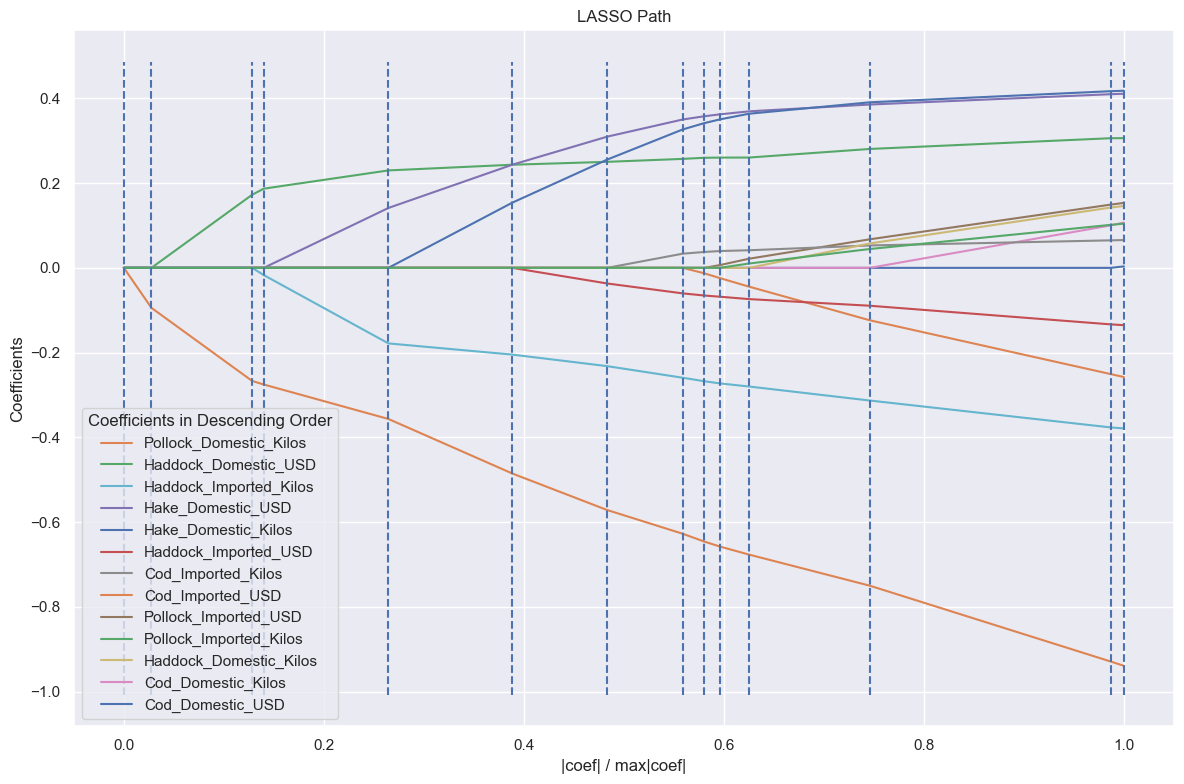

In [60]:
from sklearn.linear_model import lars_path

X_array = X_scaled.to_numpy()
y_array = y.to_numpy().ravel()


## LARS PATH
print("Computing regularization path using the LARS ...")
_, _, coefs = lars_path(X_array, y_array, method="lasso", verbose=True)

# make a coef dataframe with a col for each feature
coef_df = pd.DataFrame(coefs.T, columns=X_scaled.columns.values)

# normalize xx value
xx_df = pd.DataFrame()
xx_df['xx'] = np.sum(np.abs(coefs.T), axis=1)
xx_df['xx'] /= xx_df['xx'].iloc[-1]

# create coef_order dict
coef_order_dict = coef_df.apply(lambda x: x[x != 0].index[0] if any(x != 0) else np.nan).to_dict()

# create list of features sorted by coef_order_dict mappng
coef_order_list = sorted(coef_order_dict, key=coef_order_dict.get)
print('Coefficient Order:')
print(coef_order_list)

## plot
plt.figure(figsize=(12, 8))

# plot path for each coef
for col in coef_df.columns:
    plt.plot(xx_df['xx'], coef_df[col], label=col)

# plot vertical lines at branches
ymin, ymax = plt.ylim()
plt.vlines(xx_df, ymin, ymax, linestyle="dashed")

# order the legend using coef_order_dict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
sorted_handles = [by_label[label] for label in sorted(coef_order_dict, key=coef_order_dict.get)]
sorted_labels = sorted(coef_order_dict, key=coef_order_dict.get)
plt.legend(sorted_handles, sorted_labels, title='Coefficients in Descending Order')

# plot attributes
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.grid(True)
plt.tight_layout()
plt.show()
